In [1]:
#libs
import pandas as pd 
import os 
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
# Importando ACF e PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pytz

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Dropout
#from sklearn.preprocessing import MinMaxScaler
import math

from bcb import currency
from bcb import sgs

import plotly.graph_objects as go

import seaborn as sns

In [3]:
df = pd.read_pickle(r'C:\Users\Financeiro\Documents\GitHub\grupo_2_tera\projeto_principal\main\mastertable.pkl')

In [4]:
#atualizando os preços a partir do ipca
df['notionalusd_ipca'] = (df['notional_usd']*df['ipca'])/df['ipca_acumulado']

- normalizando os dados a partir da formula abaixo

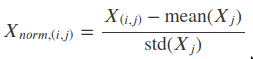

In [5]:
df['notionalusd_norm'] = (df['notional_usd'] - df['notional_usd'].mean())/df['notional_usd'].std()

In [6]:
df.head(2)

anomes mercadoria                         tipo  bolsa  \
data_referencia                                                         
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   

                unidade_negociacao      moeda  quantidade_negociada  \
data_referencia                                                       
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   

                comprador_vendedor cod_ric cod_ticker  ...  valor_cotacao  \
data_referencia                                        ...                  
2019-07-24       Mercado x Cliente    HOH0       HOH0  ...         1.9152   
2019-07-24       Mercado x Cliente    HOX0       HOX0  ...         1.8636   

                    usd  notional_usd  notional_brl  mes   ano  ipca  \
data_referencia                                                        
2019-07-24       3.7596     6595948.8  2.479813e+07    7  2019  0.19   
2019-07-24       3.7596     6418238.4  2.413001e+07    7  2019  0.19   

                 ipca_acumulado  notionalusd_ipca  notionalusd_norm  
data_referencia                                                      
2019-07-24                  2.4         522179.28          0.333448  
2019-07-24                  2.4         508110.54          0.319319  

[2 rows x 21 columns]

In [7]:
mean_df = df.resample('1M').mean()

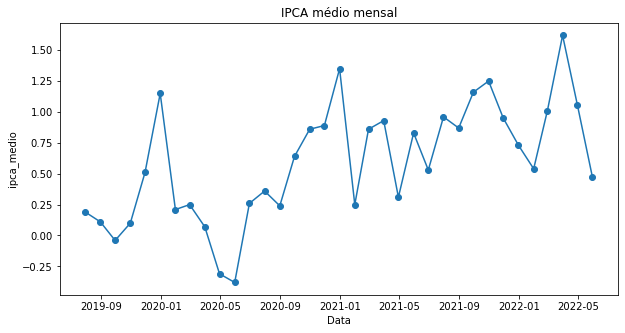

In [8]:
plt.figure(figsize=(10,5))
x = mean_df.index
y = mean_df.ipca
plt.xlabel('Data')
plt.ylabel('ipca_medio')
plt.title('IPCA médio mensal')
plt.plot(x,y, marker='o');

In [9]:
#criando um dataframe com dados diários do dolar
usd = currency.get(['USD'], start='2019-01-01', end='2022-07-14')
usd.head(2)

USD
Date              
2019-01-02  3.8595
2019-01-03  3.7683

In [10]:
#fazendo a janela movel (2 dias) mensal
#periodo: mensal
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
rolling_mean = usd.rolling(window=indexer, min_periods=2).mean()
rolling_mean = rolling_mean.shift(2) #deslocamento da janela = 2 dias
rolling_mean.head(4)

USD
Date              
2019-01-02     NaN
2019-01-03     NaN
2019-01-04  3.8139
2019-01-07  3.7655

- Fazendo alguns plots

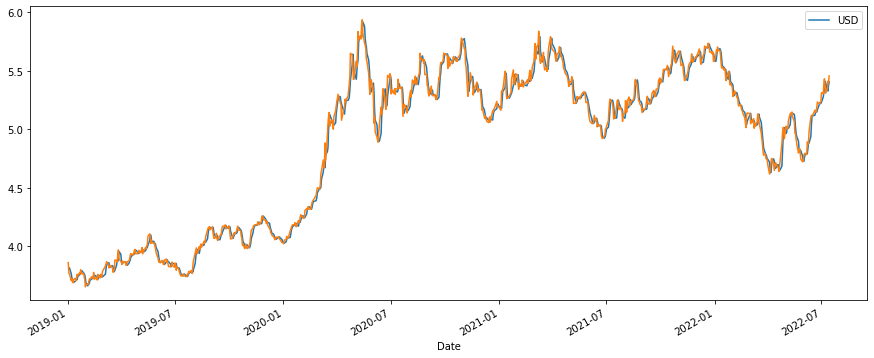

In [11]:
rolling_mean.plot(figsize=(15,6))
plt.plot(usd.index, usd.USD)

In [12]:
#plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=usd.index,y=usd['USD']))
fig.update_layout(title='Cotação diária - USD',
                  xaxis_title='Data',
                  yaxis_title='Valor em BRL')
                  #template='plotly_white')

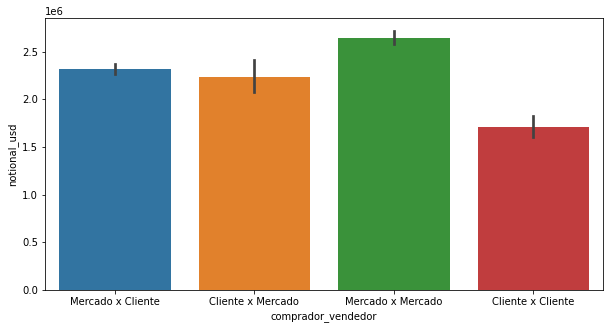

In [13]:
#seaborn
plt.figure(figsize=(10,5))
fig=sns.barplot(x=df.comprador_vendedor, y=df.notional_usd)
plt.show(fig)

KeyboardInterrupt: 

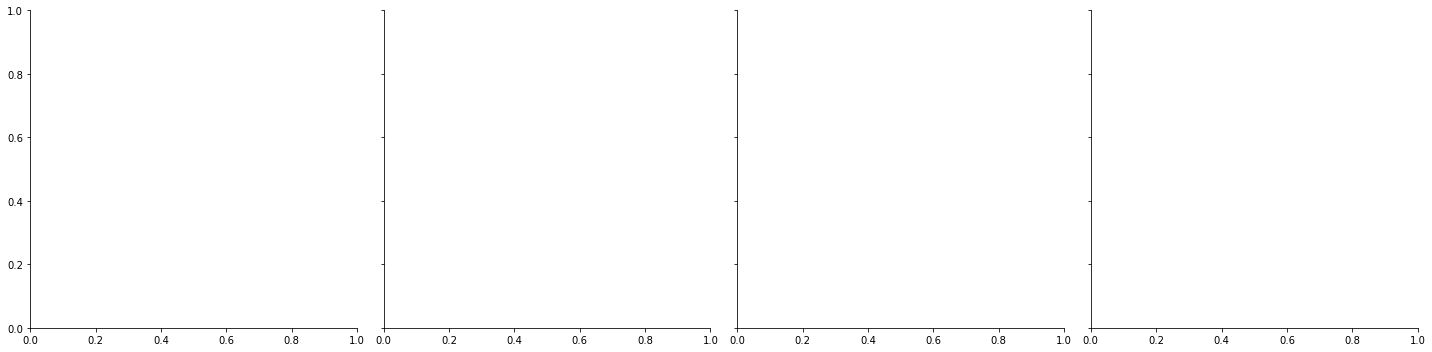

In [13]:
fig = sns.displot(data = df, x='usd', kind='kde', hue='moeda', col='comprador_vendedor')

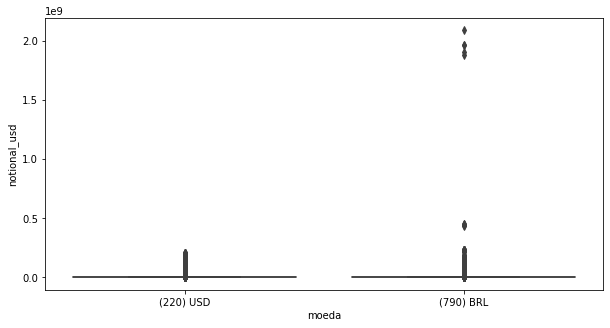

In [14]:
#seaborn
plt.figure(figsize=(10,5))
fig=sns.boxplot(x=df.moeda, y=df.notional_usd)
plt.show(fig)

- Primeiras análises da time series

In [15]:
#teste de dickey fuller
result_adf = adfuller(usd)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_adf[0]))
print('Valor-p: {:.10f}'.format(result_adf[1]))
print('Valores Críticos:')

for key, value in result_adf[4].items():
    print('\t{}: {:.4f}'.format(key, value))

if result_adf[0] < result_adf[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")        

Dickey-Fuller Aumentado
Teste Estatístico: -1.6430
Valor-p: 0.4607167493
Valores Críticos:
	1%: -3.4377
	5%: -2.8648
	10%: -2.5685
Failed to Reject Ho - Time Series is Non-Stationary


C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



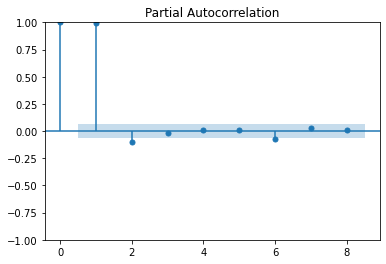

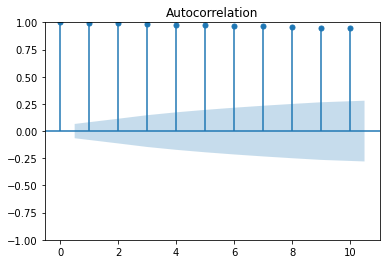

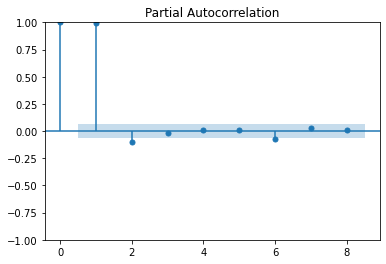

In [16]:
#análise de correlação dos lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(usd, lags=10)
plot_pacf(usd, lags=8)

<AxesSubplot:xlabel='Date'>

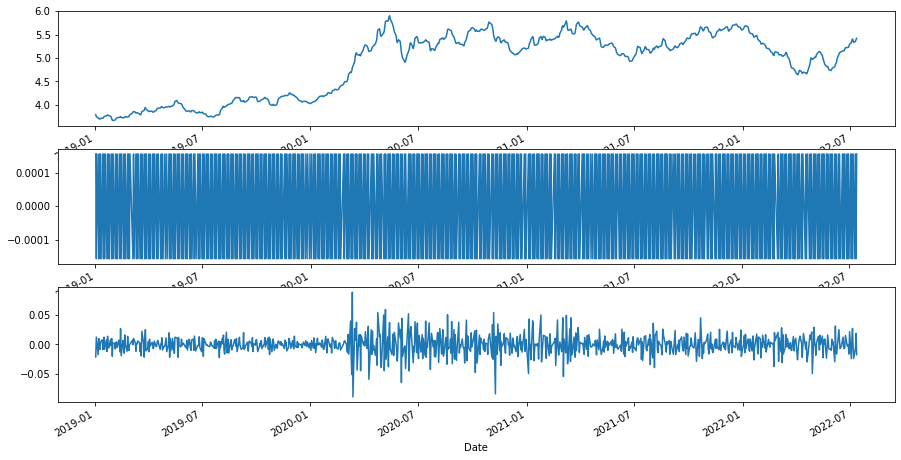

In [17]:
#decomposição temporaç
result = seasonal_decompose(usd, model='additive', period=2)
#Plotar em tamanho maior
fig, (ax2,ax3, ax4) = plt.subplots(3,1, figsize=(15,8))
#result.observed.plot(ax=ax1, ax=ax2)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)

Referências: 
    
    - Plotly: https://medium.com/swlh/plotly-beautiful-data-visualization-made-easy-3f7e48864706 
    - Timeseries: https://maxwellpaparelli.medium.com/time-series-s%C3%A9ries-temporais-com-python-f4e74fd45b0b
    - Forecasting: https://medium.com/@divyayageti/forecasting-next-day-btc-prices-using-a-high-dimensional-multivariate-data-cb833ab61183
        - https://medium.com/@melodyyip515_/time-series-analysis-and-forecasting-with-python-67488cfdf43f
        - https://medium.com/mlearning-ai/will-the-gold-price-raise-again-time-series-analysis-with-knime-and-python-3f0e271ab7d7
        -correlation: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
        -statsmodel: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
     - Monte Carlo: https://medium.com/illumination/predicting-stock-prices-using-monte-carlo-methods-in-python-2b099c408162

In [18]:
agrupmerc = df.groupby(['mercadoria'])['quantidade_negociada'].sum()
merc_maiores = agrupmerc.sort_values(ascending=False).head(10)

<AxesSubplot:xlabel='mercadoria'>

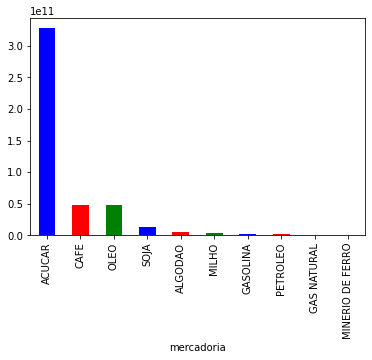

In [19]:
# Gráfico de barras das maiores COMODITIES negociadas
merc_maiores.plot.bar(color = ['blue','red', 'green'])

In [20]:
comodities = df.mercadoria.unique()
comodities 

array(['OLEO', 'COBRE', 'ALUMINIO', 'CAFE', 'ENERGIA ELETRICA', 'SOJA',
       'MILHO', 'ALGODAO', 'BOI', 'ACUCAR', 'OURO', 'PETROLEO', 'NIQUEL',
       'ETANOL', 'PLATINA', 'GASOLINA', 'ZINCO', 'SUCO DE LARANJA',
       'MINERIO DE FERRO', 'BORRACHA', 'PRATA', 'ESTANHO',
       'ACUCAR BRL D_0', 'PALADIO', 'CARVAO', 'UREIA', 'CHUMBO', 'TRIGO',
       'GAS NATURAL', 'ACO', 'BOBINA DE ACO LAMINADO', 'GASOLEO'],
      dtype=object)

In [21]:
acucar = df.loc[df['mercadoria'] == 'ACUCAR']
acucar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53639 entries, 2019-08-23 to 2022-05-17
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anomes                53639 non-null  object 
 1   mercadoria            53639 non-null  object 
 2   tipo                  53639 non-null  object 
 3   bolsa                 53639 non-null  object 
 4   unidade_negociacao    53639 non-null  object 
 5   moeda                 53639 non-null  object 
 6   quantidade_negociada  53639 non-null  int64  
 7   comprador_vendedor    53639 non-null  object 
 8   cod_ric               53639 non-null  object 
 9   cod_ticker            52015 non-null  object 
 10  fator_conversao       53639 non-null  float64
 11  valor_cotacao         53639 non-null  float64
 12  usd                   53639 non-null  float64
 13  notional_usd          53639 non-null  float64
 14  notional_brl          53639 non-null  float64
 15  me

In [22]:
acucar.head()

anomes mercadoria       tipo        bolsa unidade_negociacao  \
data_referencia                                                                
2019-08-23       20198     ACUCAR  NUMERO 11  ICE (NYBOT)              POUND   
2019-08-23       20198     ACUCAR  NUMERO 11  ICE (NYBOT)              POUND   
2019-08-23       20198     ACUCAR  NUMERO 11  ICE (NYBOT)              POUND   
2019-08-23       20198     ACUCAR  NUMERO 11  ICE (NYBOT)              POUND   
2019-08-23       20198     ACUCAR  NUMERO 11  ICE (NYBOT)              POUND   

                     moeda  quantidade_negociada comprador_vendedor cod_ric  \
data_referencia                                                               
2019-08-23       (220) USD               1120000  Mercado x Mercado   SBV1F   
2019-08-23       (220) USD               1120000  Mercado x Mercado    SBV0   
2019-08-23       (220) USD               1120000  Mercado x Mercado    SBK1   
2019-08-23       (220) USD               1120000  Mercado x Mercado    SBV9   
2019-08-23       (220) USD               1120000  Mercado x Mercado    SBK0   

                cod_ticker  ...  valor_cotacao     usd  notional_usd  \
data_referencia             ...                                        
2019-08-23             NaN  ...         0.1363  4.0851      152656.0   
2019-08-23            SBV0  ...         0.1295  4.0851      145040.0   
2019-08-23            SBK1  ...         0.1352  4.0851      151424.0   
2019-08-23            SBV9  ...         0.1147  4.0851      128464.0   
2019-08-23            SBK0  ...         0.1264  4.0851      141568.0   

                 notional_brl  mes   ano  ipca  ipca_acumulado  \
data_referencia                                                  
2019-08-23        623615.0256    8  2019  0.11            2.51   
2019-08-23        592502.9040    8  2019  0.11            2.51   
2019-08-23        618582.1824    8  2019  0.11            2.51   
2019-08-23        524788.2864    8  2019  0.11            2.51   
2019-08-23        578319.4368    8  2019  0.11            2.51   

                 notionalusd_ipca  notionalusd_norm  
data_referencia                                      
2019-08-23            6690.103586         -0.178824  
2019-08-23            6356.334661         -0.179430  
2019-08-23            6636.111554         -0.178922  
2019-08-23            5629.896414         -0.180748  
2019-08-23            6204.175299         -0.179706  

[5 rows x 21 columns]

In [23]:
acucar = acucar.resample('1M').mean()

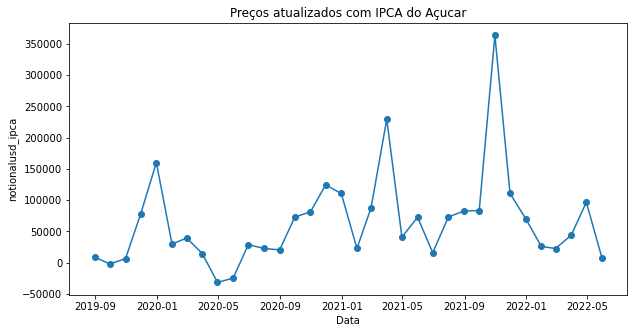

In [24]:
plt.figure(figsize=(10,5))
x = acucar.index
y = acucar.notionalusd_ipca
plt.xlabel('Data')
plt.ylabel('notionalusd_ipca')
plt.title('Preços atualizados com IPCA do Açucar')
plt.plot(x,y, marker='o');

In [25]:
#teste de dickey fuller
result_acucar = adfuller(acucar.notionalusd_ipca)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_adf[0]))
print('Valor-p: {:.10f}'.format(result_adf[1]))
print('Valores Críticos:')

for key, value in result_adf[4].items():
    print('\t{}: {:.4f}'.format(key, value))
    
if result_adf[0] < result_adf[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")        

Dickey-Fuller Aumentado
Teste Estatístico: -1.6430
Valor-p: 0.4607167493
Valores Críticos:
	1%: -3.4377
	5%: -2.8648
	10%: -2.5685
Failed to Reject Ho - Time Series is Non-Stationary


<AxesSubplot:xlabel='data_referencia'>

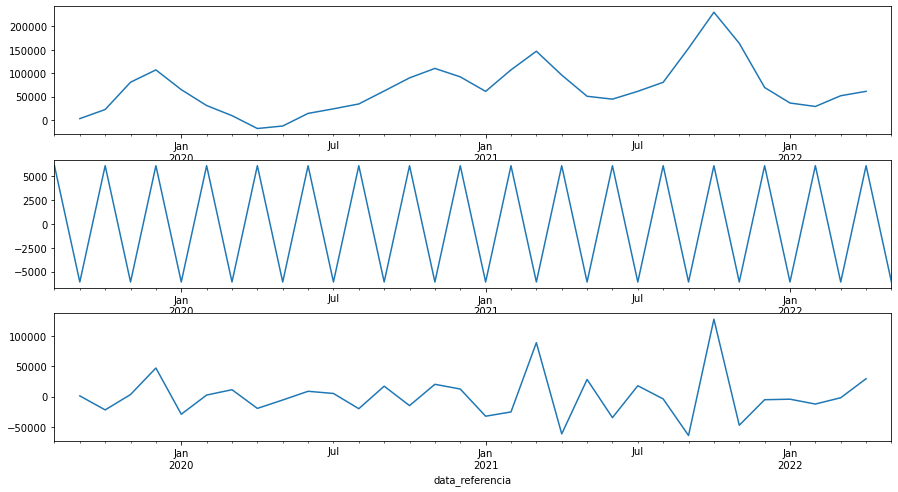

In [26]:
#decomposição temporaç
result_acucar = seasonal_decompose(acucar.notionalusd_ipca, model='aditive',period=2)
#Plotar em tamanho maior
fig, (ax2,ax3, ax4) = plt.subplots(3,1, figsize=(15,8))
#result_acucar.observed.plot(ax=ax1)
result_acucar.trend.plot(ax=ax2)
result_acucar.seasonal.plot(ax=ax3)
result_acucar.resid.plot(ax=ax4)


C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



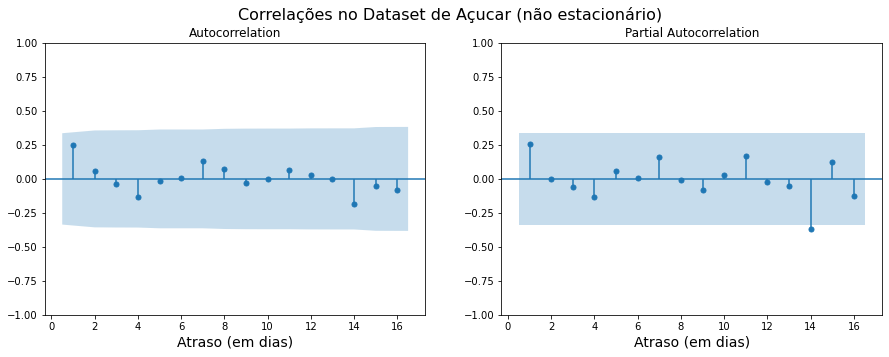

In [27]:
# Construindo os gráficos
fig, ax = plt.subplots(1,2,figsize=(15,5)) # Para facilitar, vamos fazer um grid de dois gráficos, na horizontal
plot_acf(acucar.notionalusd_ipca,ax=ax[0],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[0].set_xlabel('Atraso (em dias)',size=14)
plot_pacf(acucar.notionalusd_ipca,ax=ax[1],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[1].set_xlabel('Atraso (em dias)',size=14)
plt.suptitle("Correlações no Dataset de Açucar (não estacionário)",size=16)
plt.show()

In [28]:
# O comando .diff() faz a diferença entre linhas consecutivas do dataset!
acucar['Diferenca'] = acucar.notionalusd_ipca.diff()


In [29]:
acucar.head()

quantidade_negociada  fator_conversao  valor_cotacao  \
data_referencia                                                         
2019-08-31               1.504000e+06             0.01       0.131021   
2019-09-30               1.061486e+06             0.01       0.129851   
2019-10-31               1.209026e+06             0.01       0.135591   
2019-11-30               3.522400e+06             0.01       0.133899   
2019-12-31               4.254164e+06             0.01       0.138641   

                      usd   notional_usd  notional_brl  ipca  ipca_acumulado  \
data_referencia                                                                
2019-08-31       4.124443  197491.610256  8.128686e+05  0.11            2.51   
2019-09-30       4.151808  136410.971429  5.654868e+05 -0.04            2.47   
2019-10-31       4.170518  163847.145299  6.836324e+05  0.10            2.57   
2019-11-30       4.158673  471041.324444  1.962264e+06  0.51            3.08   
2019-12-31       4.107357  588923.520583  2.424527e+06  1.15            4.23   

                 notionalusd_ipca  notionalusd_norm     Diferenca  
data_referencia                                                    
2019-08-31            8655.010808         -0.175260           NaN  
2019-09-30           -2209.084558         -0.180116 -10864.095366  
2019-10-31            6375.375303         -0.177935   8584.459861  
2019-11-30           77997.102424         -0.153511  71621.727121  
2019-12-31          160109.231364         -0.144139  82112.128940

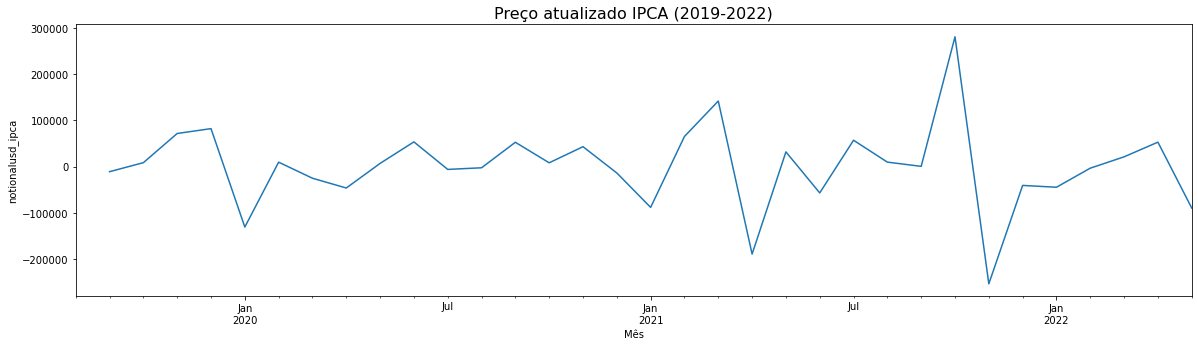

In [30]:
# Gráfico dos dados
plt.figure(figsize=(20,5))
acucar.Diferenca.plot(kind='line')
plt.xlabel('Mês')
plt.ylabel('notionalusd_ipca')
plt.title('Preço atualizado IPCA (2019-2022)',size=16)
plt.show()

In [31]:
# Testando estacionariedade
teste_diferenca = adfuller(acucar.Diferenca.dropna()) # O primeiro registro é NaN então excluímos!
print('p-valor (<.05 indica estacionariedade) desta série é {}'.format(teste_diferenca[1]))


p-valor (<.05 indica estacionariedade) desta série é 2.3228205981705583e-12


In [32]:
#função para plotar correlação
def plota_correlacoes(dataset, nome_dataset, unidade):
    fig, ax = plt.subplots(1,2,figsize=(15,5)) # Para facilitar, vamos fazer um grid de dois gráficos, na horizontal
    plot_acf(dataset,ax=ax[0],lags=10,zero=False) # Sem a ACF(0)
    ax[0].set_xlabel('Atraso (em {})'.format(unidade),size=14)
    plot_pacf(dataset,ax=ax[1],lags=8,zero=False) # Sem a PACF(0)
    ax[1].set_xlabel('Atraso (em {})'.format(unidade),size=14)
    plt.suptitle("Correlações no Dataset de {}".format(nome_dataset,size=16))
    plt.show()
    return None # Não precisamos retornar nada

C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



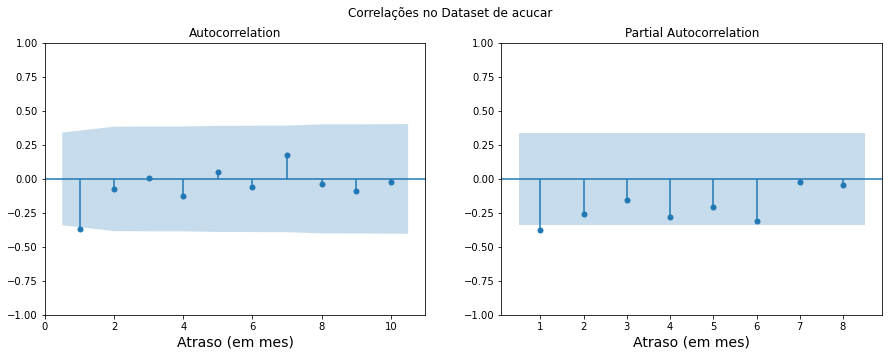

In [33]:
# Construindo novamente o ACF e o PACF
plota_correlacoes(acucar.Diferenca.dropna(), unidade='mes',nome_dataset='acucar')

In [34]:
cafe = df.loc[df['mercadoria'] == 'CAFE']
cafe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56403 entries, 2019-07-24 to 2022-05-18
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anomes                56403 non-null  object 
 1   mercadoria            56403 non-null  object 
 2   tipo                  56403 non-null  object 
 3   bolsa                 56403 non-null  object 
 4   unidade_negociacao    56403 non-null  object 
 5   moeda                 56403 non-null  object 
 6   quantidade_negociada  56403 non-null  int64  
 7   comprador_vendedor    56403 non-null  object 
 8   cod_ric               56403 non-null  object 
 9   cod_ticker            53100 non-null  object 
 10  fator_conversao       56403 non-null  float64
 11  valor_cotacao         56403 non-null  float64
 12  usd                   56403 non-null  float64
 13  notional_usd          56403 non-null  float64
 14  notional_brl          56403 non-null  float64
 15  me

In [35]:
cafe = cafe.resample('1M').mean()

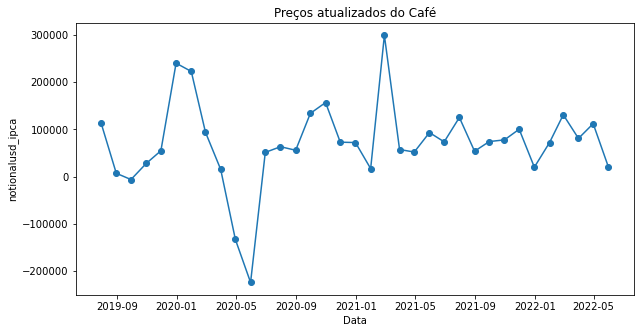

In [36]:
plt.figure(figsize=(10,5))
x = cafe.index
y = cafe.notionalusd_ipca
plt.xlabel('Data')
plt.ylabel('notionalusd_ipca')
plt.title('Preços atualizados do Café')
plt.plot(x,y, marker='o');

In [37]:
#teste de dickey fuller
result_cafe = adfuller(cafe.notionalusd_ipca)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_adf[0]))
print('Valor-p: {:.10f}'.format(result_adf[1]))
print('Valores Críticos:')

for key, value in result_adf[4].items():
    print('\t{}: {:.4f}'.format(key, value))

if result_adf[0] < result_adf[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")    

Dickey-Fuller Aumentado
Teste Estatístico: -1.6430
Valor-p: 0.4607167493
Valores Críticos:
	1%: -3.4377
	5%: -2.8648
	10%: -2.5685
Failed to Reject Ho - Time Series is Non-Stationary


<AxesSubplot:xlabel='data_referencia'>

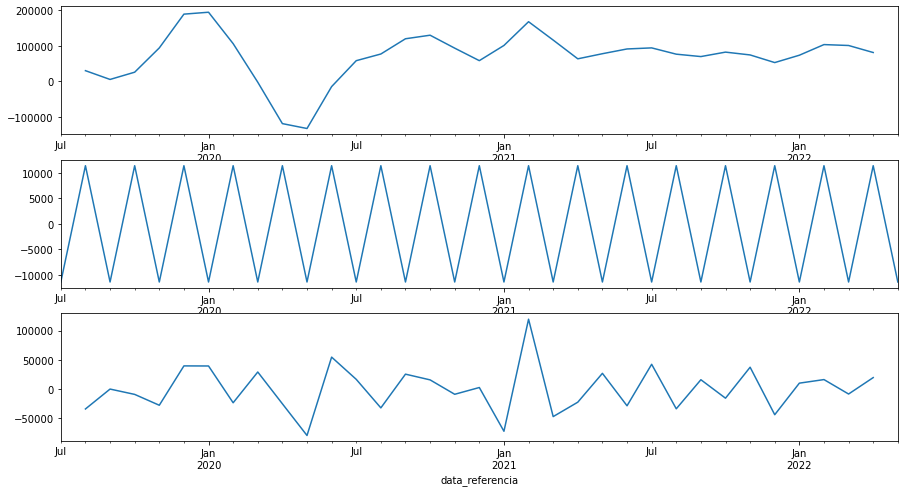

In [38]:
#decomposição temporaç
result_cafe = seasonal_decompose(cafe.notionalusd_ipca, model='aditive',period=2)
#Plotar em tamanho maior
fig, (ax2,ax3, ax4) = plt.subplots(3,1, figsize=(15,8))
#result_acucar.observed.plot(ax=ax1)
result_cafe.trend.plot(ax=ax2)
result_cafe.seasonal.plot(ax=ax3)
result_cafe.resid.plot(ax=ax4)

C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



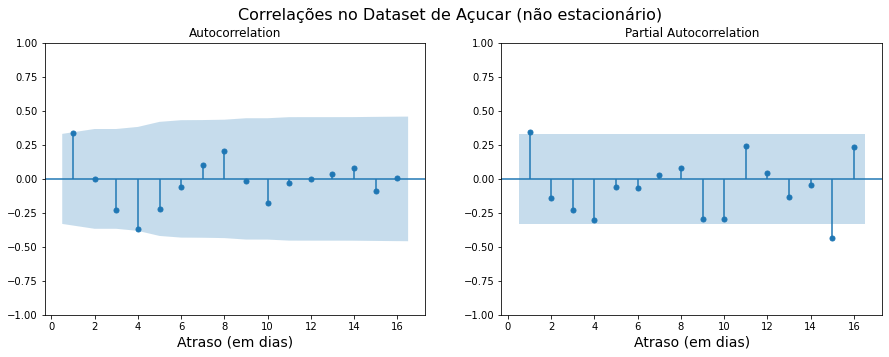

In [39]:
# Construindo os gráficos
fig, ax = plt.subplots(1,2,figsize=(15,5)) # Para facilitar, vamos fazer um grid de dois gráficos, na horizontal
plot_acf(cafe.notionalusd_ipca,ax=ax[0],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[0].set_xlabel('Atraso (em dias)',size=14)
plot_pacf(cafe.notionalusd_ipca,ax=ax[1],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[1].set_xlabel('Atraso (em dias)',size=14)
plt.suptitle("Correlações no Dataset de Açucar (não estacionário)",size=16)
plt.show()

In [40]:
# O comando .diff() faz a diferença entre linhas consecutivas do dataset!
cafe['Diferenca'] = cafe.notionalusd_ipca.diff()


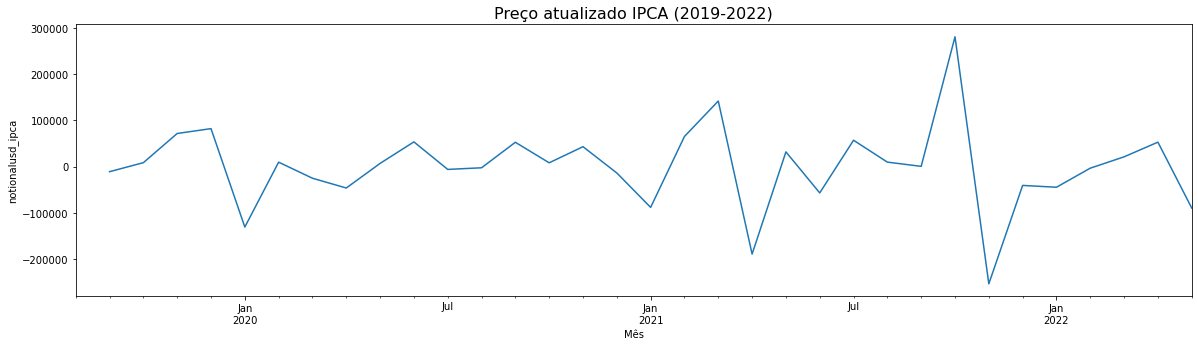

In [41]:
# Gráfico dos dados
plt.figure(figsize=(20,5))
acucar.Diferenca.plot(kind='line')
plt.xlabel('Mês')
plt.ylabel('notionalusd_ipca')
plt.title('Preço atualizado IPCA (2019-2022)',size=16)
plt.show()

In [42]:
# Testando estacionariedade
teste_cafe_diferenca = adfuller(cafe.Diferenca.dropna()) # O primeiro registro é NaN então excluímos!
print('p-valor (<.05 indica estacionariedade) desta série é {}'.format(teste_cafe_diferenca[1]))


p-valor (<.05 indica estacionariedade) desta série é 5.932108282030094e-10


C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



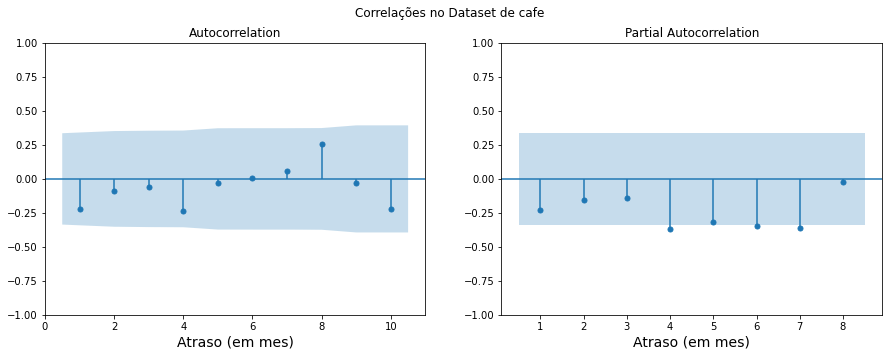

In [43]:
# Construindo novamente o ACF e o PACF
plota_correlacoes(cafe.Diferenca.dropna(), unidade='mes',nome_dataset='cafe')

In [44]:
oleo = df.loc[df['mercadoria'] == 'OLEO']
oleo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8023 entries, 2019-07-24 to 2022-05-17
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   anomes                8023 non-null   object 
 1   mercadoria            8023 non-null   object 
 2   tipo                  8023 non-null   object 
 3   bolsa                 8023 non-null   object 
 4   unidade_negociacao    8023 non-null   object 
 5   moeda                 8023 non-null   object 
 6   quantidade_negociada  8023 non-null   int64  
 7   comprador_vendedor    8023 non-null   object 
 8   cod_ric               8023 non-null   object 
 9   cod_ticker            8023 non-null   object 
 10  fator_conversao       8023 non-null   float64
 11  valor_cotacao         8023 non-null   float64
 12  usd                   8023 non-null   float64
 13  notional_usd          8023 non-null   float64
 14  notional_brl          8023 non-null   float64
 15  mes

In [45]:
oleo = oleo.resample('1M').mean()

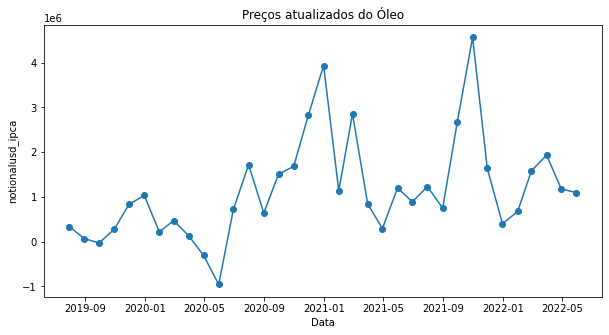

In [46]:
plt.figure(figsize=(10,5))
x = oleo.index
y = oleo.notionalusd_ipca
plt.xlabel('Data')
plt.ylabel('notionalusd_ipca')
plt.title('Preços atualizados do Óleo')
plt.plot(x,y, marker='o');

In [47]:
#teste de dickey fuller
result_oleo = adfuller(oleo.notionalusd_ipca)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_adf[0]))
print('Valor-p: {:.10f}'.format(result_adf[1]))
print('Valores Críticos:')

for key, value in result_adf[4].items():
    print('\t{}: {:.4f}'.format(key, value))
    
if result_adf[0] < result_adf[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")        

Dickey-Fuller Aumentado
Teste Estatístico: -1.6430
Valor-p: 0.4607167493
Valores Críticos:
	1%: -3.4377
	5%: -2.8648
	10%: -2.5685
Failed to Reject Ho - Time Series is Non-Stationary


<AxesSubplot:xlabel='data_referencia'>

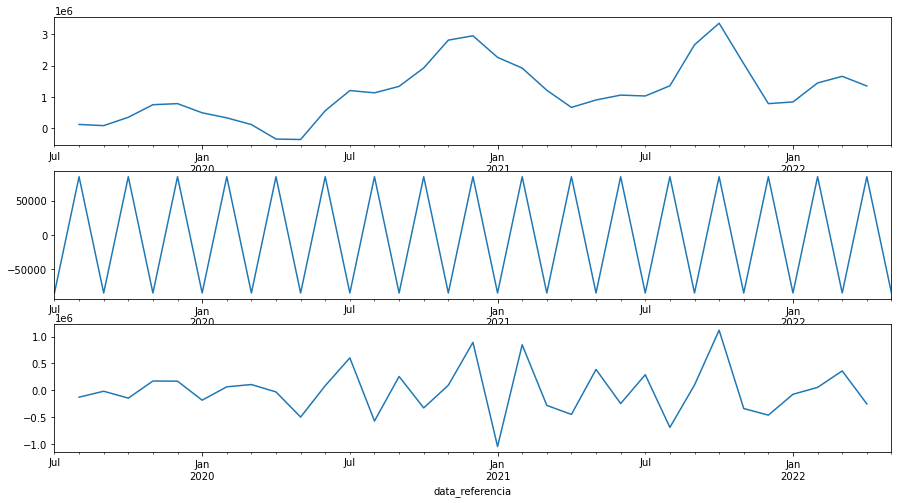

In [48]:
#decomposição temporaç
result_oleo = seasonal_decompose(oleo.notionalusd_ipca, model='aditive',period=2)
#Plotar em tamanho maior
fig, (ax2,ax3, ax4) = plt.subplots(3,1, figsize=(15,8))
#result_acucar.observed.plot(ax=ax1)
result_oleo.trend.plot(ax=ax2)
result_oleo.seasonal.plot(ax=ax3)
result_oleo.resid.plot(ax=ax4)

C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



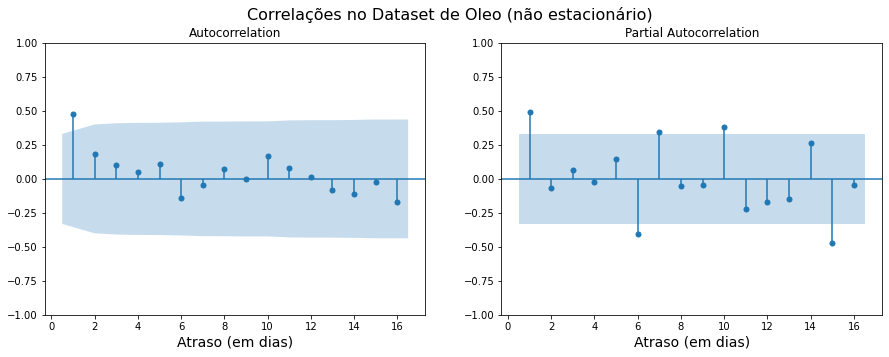

In [49]:
# Construindo os gráficos
fig, ax = plt.subplots(1,2,figsize=(15,5)) # Para facilitar, vamos fazer um grid de dois gráficos, na horizontal
plot_acf(oleo.notionalusd_ipca,ax=ax[0],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[0].set_xlabel('Atraso (em dias)',size=14)
plot_pacf(oleo.notionalusd_ipca,ax=ax[1],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[1].set_xlabel('Atraso (em dias)',size=14)
plt.suptitle("Correlações no Dataset de Oleo (não estacionário)",size=16)
plt.show()

In [50]:
# O comando .diff() faz a diferença entre linhas consecutivas do dataset!
oleo['Diferenca'] = oleo.notionalusd_ipca.diff()

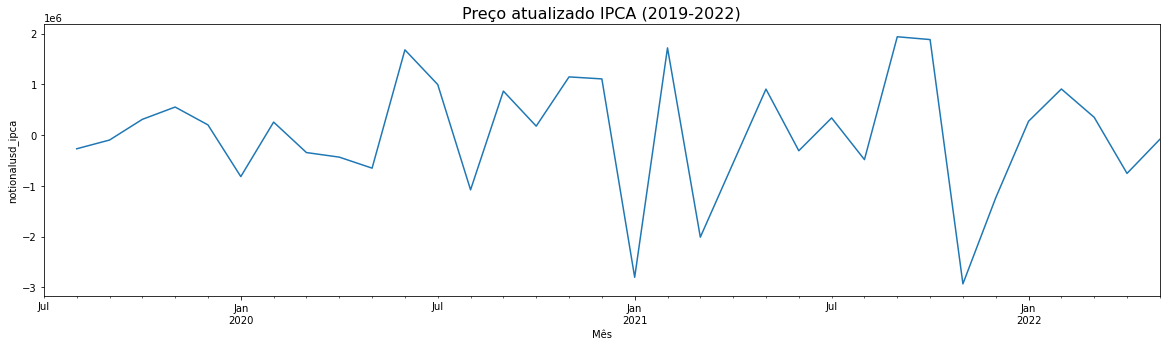

In [51]:
# Gráfico dos dados
plt.figure(figsize=(20,5))
oleo.Diferenca.plot(kind='line')
plt.xlabel('Mês')
plt.ylabel('notionalusd_ipca')
plt.title('Preço atualizado IPCA (2019-2022)',size=16)
plt.show()

In [52]:
# Testando estacionariedade
teste_oleo_diferenca = adfuller(oleo.Diferenca.dropna()) # O primeiro registro é NaN então excluímos!
print('p-valor (<.05 indica estacionariedade) desta série é {}'.format(teste_oleo_diferenca[1]))


p-valor (<.05 indica estacionariedade) desta série é 0.019976810640964408


C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



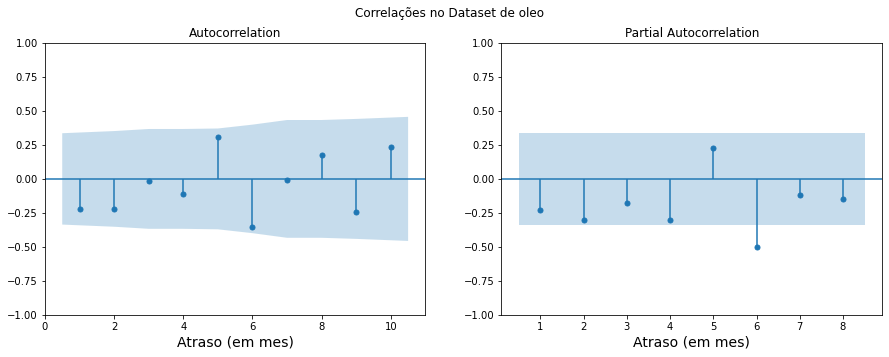

In [53]:
# Construindo novamente o ACF e o PACF
plota_correlacoes(oleo.Diferenca.dropna(), unidade='mes',nome_dataset='oleo')

In [54]:
soja = df.loc[df['mercadoria'] == 'SOJA']

In [55]:
soja = soja.resample('1M').mean()

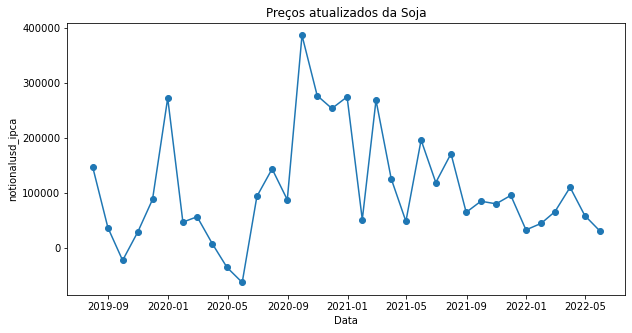

In [56]:
plt.figure(figsize=(10,5))
x = soja.index
y = soja.notionalusd_ipca
plt.xlabel('Data')
plt.ylabel('notionalusd_ipca')
plt.title('Preços atualizados da Soja')
plt.plot(x,y, marker='o');

In [57]:
#teste de dickey fuller
result_soja = adfuller(soja.notionalusd_ipca)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_adf[0]))
print('Valor-p: {:.10f}'.format(result_adf[1]))
print('Valores Críticos:')

for key, value in result_adf[4].items():
    print('\t{}: {:.4f}'.format(key, value))
    
if result_adf[0] < result_adf[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")    

Dickey-Fuller Aumentado
Teste Estatístico: -1.6430
Valor-p: 0.4607167493
Valores Críticos:
	1%: -3.4377
	5%: -2.8648
	10%: -2.5685
Failed to Reject Ho - Time Series is Non-Stationary


<AxesSubplot:xlabel='data_referencia'>

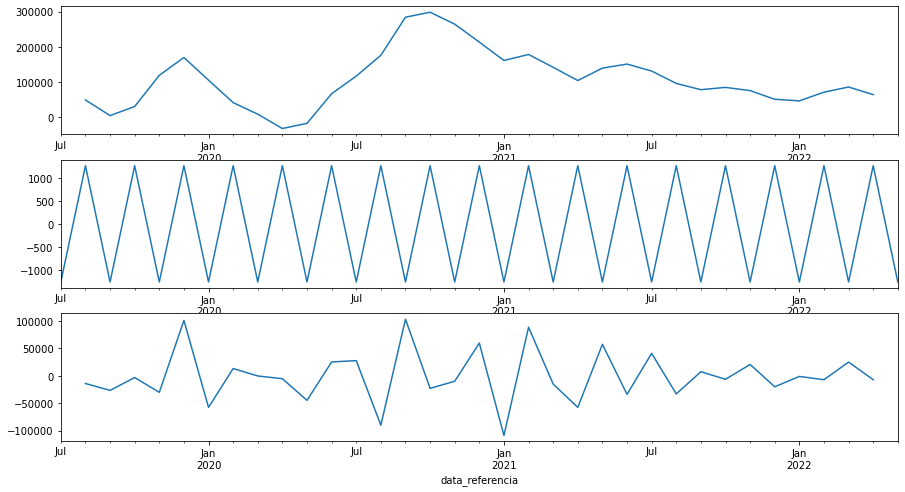

In [58]:
#decomposição temporaç
result_soja = seasonal_decompose(soja.notionalusd_ipca, model='aditive',period=2)
#Plotar em tamanho maior
fig, (ax2,ax3, ax4) = plt.subplots(3,1, figsize=(15,8))
#result_acucar.observed.plot(ax=ax1)
result_soja.trend.plot(ax=ax2)
result_soja.seasonal.plot(ax=ax3)
result_soja.resid.plot(ax=ax4)

C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



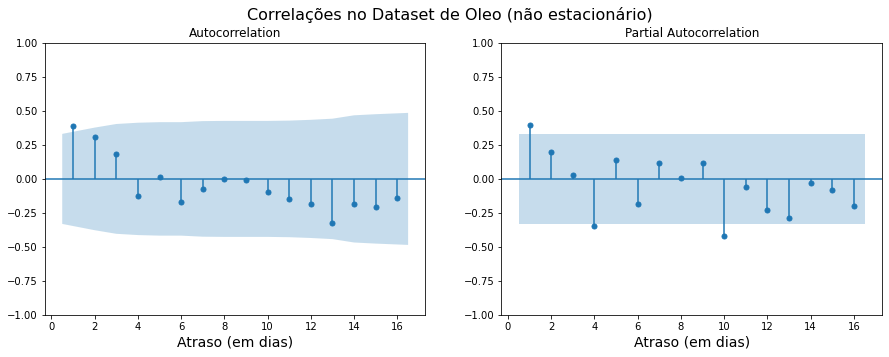

In [59]:
# Construindo os gráficos
fig, ax = plt.subplots(1,2,figsize=(15,5)) # Para facilitar, vamos fazer um grid de dois gráficos, na horizontal
plot_acf(soja.notionalusd_ipca,ax=ax[0],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[0].set_xlabel('Atraso (em dias)',size=14)
plot_pacf(soja.notionalusd_ipca,ax=ax[1],zero=False) # Precisamos indicar apenas a coluna com a série temporal em sí
ax[1].set_xlabel('Atraso (em dias)',size=14)
plt.suptitle("Correlações no Dataset de Oleo (não estacionário)",size=16)
plt.show()

In [60]:
# O comando .diff() faz a diferença entre linhas consecutivas do dataset!
soja['Diferenca'] = soja.notionalusd_ipca.diff()

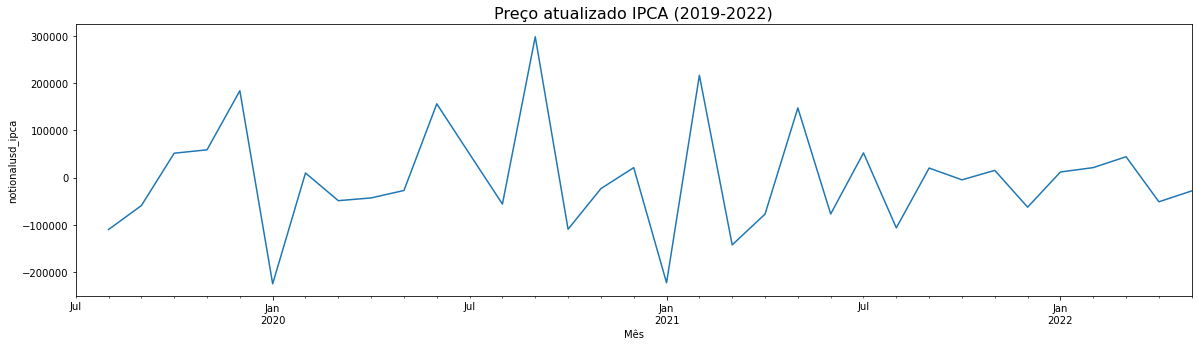

In [61]:
# Gráfico dos dados
plt.figure(figsize=(20,5))
soja.Diferenca.plot(kind='line')
plt.xlabel('Mês')
plt.ylabel('notionalusd_ipca')
plt.title('Preço atualizado IPCA (2019-2022)',size=16)
plt.show()

In [62]:
# Testando estacionariedade
teste_soja_diferenca = adfuller(soja.Diferenca.dropna()) # O primeiro registro é NaN então excluímos!
print('p-valor (<.05 indica estacionariedade) desta série é {}'.format(teste_soja_diferenca[1]))

p-valor (<.05 indica estacionariedade) desta série é 0.43276977665691274


C:\Users\Financeiro\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



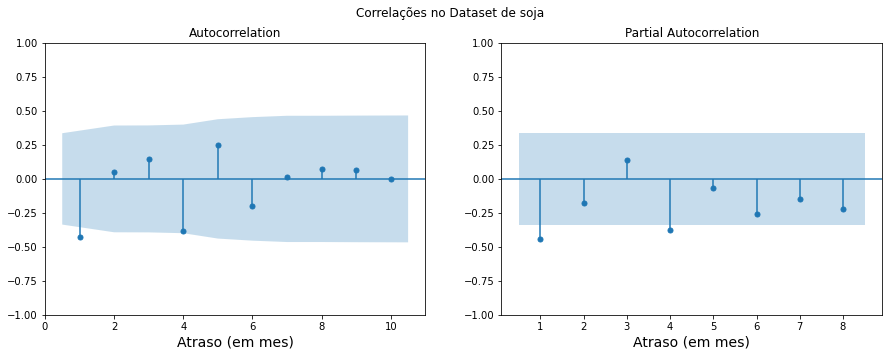

In [63]:
# Construindo novamente o ACF e o PACF
plota_correlacoes(soja.Diferenca.dropna(), unidade='mes',nome_dataset='soja')

In [64]:
soja.head()
#usando boxcox
#soja_box= stats.boxcox(soja.notionalusd_ipca)

quantidade_negociada  fator_conversao  valor_cotacao  \
data_referencia                                                         
2019-07-31              200000.000000         0.010000       9.260250   
2019-08-31               58906.377432         0.117860      40.738833   
2019-09-30               60752.819355         0.448581     138.626661   
2019-10-31              213990.296496         0.010000       9.160267   
2019-11-30              185565.305040         0.057268      22.758066   

                      usd  notional_usd  notional_brl  ipca  ipca_acumulado  \
data_referencia                                                               
2019-07-31       3.759600  1.852050e+06  6.962967e+06  0.19            2.40   
2019-08-31       4.149874  8.313886e+05  3.443651e+06  0.11            2.51   
2019-09-30       4.124038  1.418656e+06  5.843326e+06 -0.04            2.47   
2019-10-31       4.097660  7.394924e+05  3.020288e+06  0.10            2.57   
2019-11-30       4.127393  5.299164e+05  2.173461e+06  0.51            3.08   

                 notionalusd_ipca  notionalusd_norm      Diferenca  
data_referencia                                                     
2019-07-31          146620.625000         -0.043715            NaN  
2019-08-31           36435.356424         -0.124862 -110185.268576  
2019-09-30          -22974.189315         -0.078171  -59409.545739  
2019-10-31           28774.024052         -0.132168   51748.213367  
2019-11-30           87745.897710         -0.148830   58971.873658

In [65]:
# Creating general function to test stationarity of a time series

def test_stationarity(timeseries):
    # Rolling Mean & Rolling Standard Deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    plt.figure(figsize = (15,6))
    orig = plt.plot(timeseries, color = 'blue', label ='Original')
    mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
    plt.legend(loc = 'best')
    plt.show()
    
    # Augmented Dicky-Fuller Test
    print('-------------Results of Dicky Fuller Test -------------')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(data = dftest[0:4], index = ['Test Statistic : adf', 'p-value : MacKinnon\'s approximate p-value',
                                                     'No. of Lags used', 'No. of observations used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    dfoutput['Maximized AIC:'] = dftest[5]
    print(dfoutput)

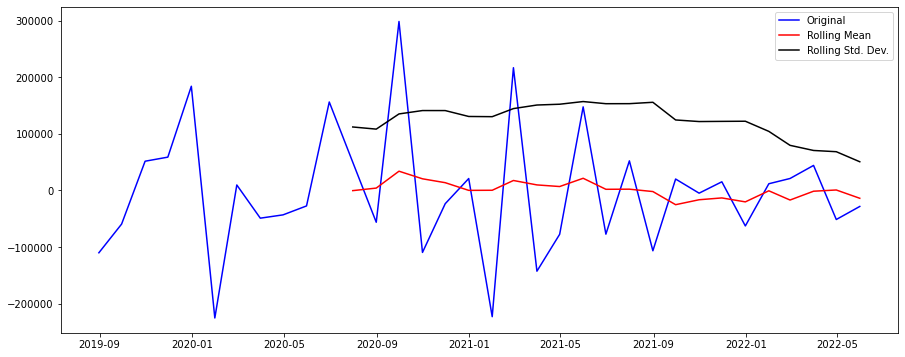

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -1.696785
p-value : MacKinnon's approximate p-value      0.432770
No. of Lags used                               8.000000
No. of observations used                      25.000000
Critical Value (1%)                           -3.723863
Critical Value (5%)                           -2.986489
Critical Value (10%)                          -2.632800
Maximized AIC:                               589.229035
dtype: float64


In [66]:
test_stationarity(soja.Diferenca.dropna())

In [67]:
#Making Time Series Stationary
#The trend and seasonality components contribute to the non-stationarity of the time series.
#here are three ways in which we can make time series stationary :-
#Transformation : We can use various transformations like log, inverse, square root, box-cox, exponential etc.Common one is log transformation
#Removing trend component from time series using smoothing technique : Smoothing technique can include moving avg, exponential weighted moving avg, LOESS etc.
#Differencing : Difference between y(t) and y(t-k) for differencing of order k

C:\Users\Financeiro\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

invalid value encountered in log



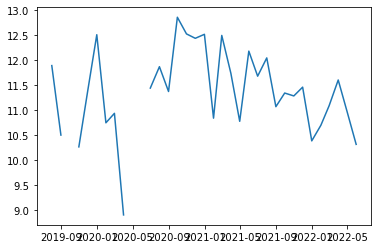

In [68]:
# Log Transformation
soja_log = np.log(soja.notionalusd_ipca)
plt.plot(soja_log)

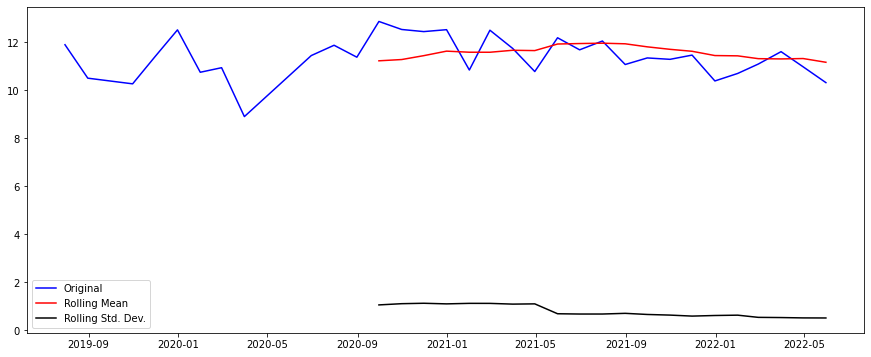

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                         -1.167520
p-value : MacKinnon's approximate p-value     0.687409
No. of Lags used                              9.000000
No. of observations used                     22.000000
Critical Value (1%)                          -3.769733
Critical Value (5%)                          -3.005426
Critical Value (10%)                         -2.642501
Maximized AIC:                               46.302426
dtype: float64


In [69]:
# Stationarity test of log transformed soja
test_stationarity(soja_log.dropna())

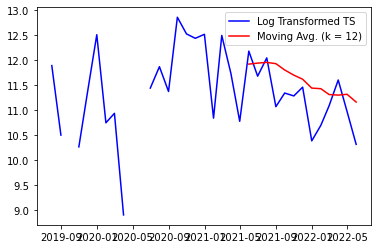

In [70]:
# Smoothing method : We will subtract Moving Avg. value from log transformed soja and then check its stationarity
mov_avg = soja_log.rolling(window = 12).mean()
plt.plot(soja_log, color = 'blue', label ='Log Transformed TS')
plt.plot(mov_avg, color = 'red', label = 'Moving Avg. (k = 12)')
plt.legend(loc = 'best')
plt.show()

In [71]:
soja_log_smu = soja_log - mov_avg
# Removing NA values from differenced soja
soja_log_smu = soja_log_smu.dropna()
soja_log_smu

data_referencia
2021-05-31    0.260149
2021-06-30   -0.261447
2021-07-31    0.089843
2021-08-31   -0.861990
2021-09-30   -0.462020
2021-10-31   -0.416360
2021-11-30   -0.159014
2021-12-31   -1.057309
2022-01-31   -0.733065
2022-02-28   -0.224776
2022-03-31    0.302677
2022-04-30   -0.343723
2022-05-31   -0.847308
Freq: M, Name: notionalusd_ipca, dtype: float64

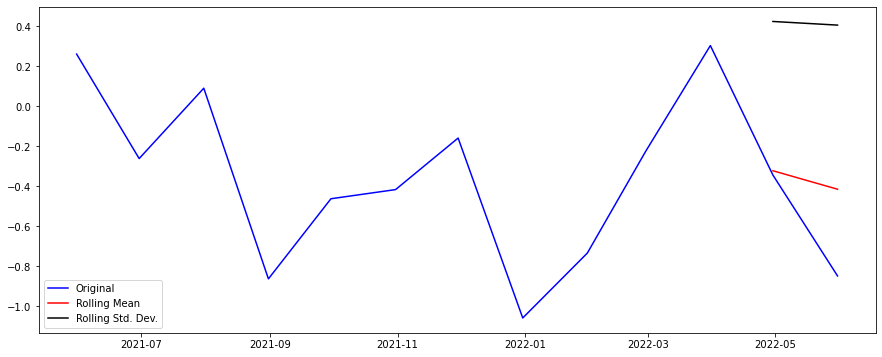

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                        -1.243977
p-value : MacKinnon's approximate p-value    0.654398
No. of Lags used                             4.000000
No. of observations used                     8.000000
Critical Value (1%)                         -4.665186
Critical Value (5%)                         -3.367187
Critical Value (10%)                        -2.802961
Maximized AIC:                               2.182625
dtype: float64


In [72]:
# Checking stationarity of de-trended log transformed TS
test_stationarity(soja_log_smu)

mercadoria
ACUCAR     AxesSubplot(0.125,0.2;0.775x0.68)
ALGODAO    AxesSubplot(0.125,0.2;0.775x0.68)
CAFE       AxesSubplot(0.125,0.2;0.775x0.68)
MILHO      AxesSubplot(0.125,0.2;0.775x0.68)
OLEO       AxesSubplot(0.125,0.2;0.775x0.68)
SOJA       AxesSubplot(0.125,0.2;0.775x0.68)
Name: notionalusd_ipca, dtype: object

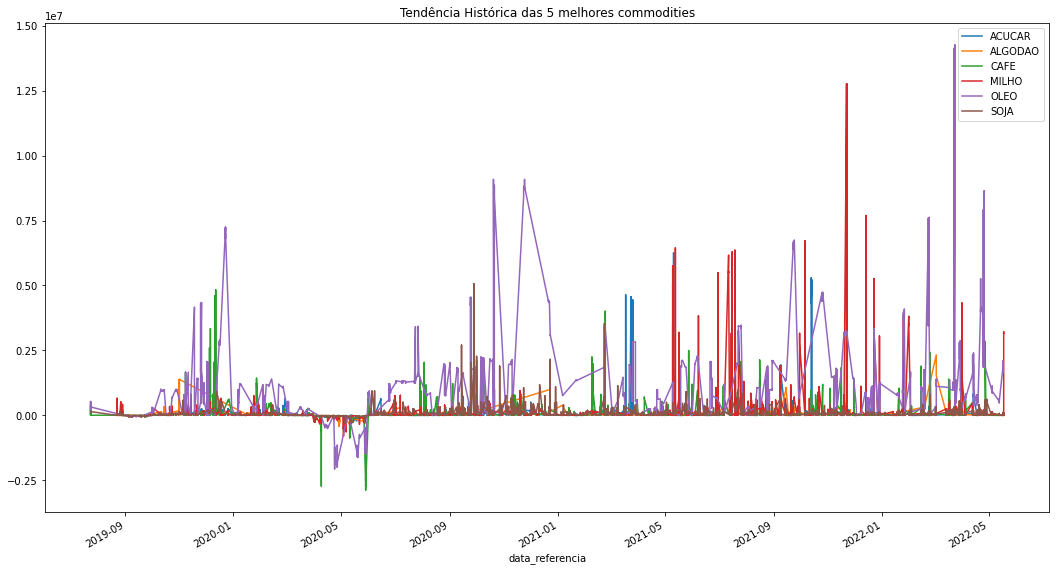

In [73]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 10
df[df.mercadoria.isin(['ACUCAR','CAFE','OLEO','SOJA','ALGODAO','MILHO'])].groupby('mercadoria').notionalusd_ipca.plot(title='Tendência Histórica das 5 melhores commodities', legend=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242578 entries, 2019-07-24 to 2022-05-18
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   anomes                242578 non-null  object 
 1   mercadoria            242578 non-null  object 
 2   tipo                  242578 non-null  object 
 3   bolsa                 242578 non-null  object 
 4   unidade_negociacao    242578 non-null  object 
 5   moeda                 242578 non-null  object 
 6   quantidade_negociada  242578 non-null  int64  
 7   comprador_vendedor    242578 non-null  object 
 8   cod_ric               242523 non-null  object 
 9   cod_ticker            237308 non-null  object 
 10  fator_conversao       242578 non-null  float64
 11  valor_cotacao         242578 non-null  float64
 12  usd                   242578 non-null  float64
 13  notional_usd          242578 non-null  float64
 14  notional_brl          242578 non-nul

In [75]:
df.head(10)

anomes mercadoria                         tipo  bolsa  \
data_referencia                                                         
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   

                unidade_negociacao      moeda  quantidade_negociada  \
data_referencia                                                       
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   

                comprador_vendedor cod_ric cod_ticker  ...  valor_cotacao  \
data_referencia                                        ...                  
2019-07-24       Mercado x Cliente    HOH0       HOH0  ...         1.9152   
2019-07-24       Mercado x Cliente    HOX0       HOX0  ...         1.8636   
2019-07-24       Mercado x Cliente    HOJ1       HOJ1  ...         1.8315   
2019-07-24       Mercado x Cliente    HOV9       HOV9  ...         1.9676   
2019-07-24       Mercado x Cliente    HOX9       HOX9  ...         1.9630   
2019-07-24       Mercado x Cliente    HOZ9       HOZ9  ...         1.9556   
2019-07-24       Mercado x Cliente    HOV0       HOV0  ...         1.8624   
2019-07-24       Mercado x Cliente    HOF0       HOF0  ...         1.9465   
2019-07-24       Mercado x Cliente    HOQ0       HOQ0  ...         1.8616   
2019-07-24       Mercado x Cliente    HOH1       HOH1  ...         1.8478   

                    usd  notional_usd  notional_brl  mes   ano  ipca  \
data_referencia                                                        
2019-07-24       3.7596     6595948.8  2.479813e+07    7  2019  0.19   
2019-07-24       3.7596     6418238.4  2.413001e+07    7  2019  0.19   
2019-07-24       3.7596     6307686.0  2.371438e+07    7  2019  0.19   
2019-07-24       3.7596     6776414.4  2.547661e+07    7  2019  0.19   
2019-07-24       3.7596     6760572.0  2.541705e+07    7  2019  0.19   
2019-07-24       3.7596     6735086.4  2.532123e+07    7  2019  0.19   
2019-07-24       3.7596     6414105.6  2.411447e+07    7  2019  0.19   
2019-07-24       3.7596     6703746.0  2.520340e+07    7  2019  0.19   
2019-07-24       3.7596     6411350.4  2.410411e+07    7  2019  0.19   
2019-07-24       3.7596     6363823.2  2.392543e+07    7  2019  0.19   

                 ipca_acumulado  notionalusd_ipca  notionalusd_norm  
data_referencia                                                      
2019-07-24                  2.4        522179.280          0.333448  
2019-07-24                  2.4        508110.540          0.319319  
2019-07-24                  2.4        499358.475          0.310530  
2019-07-24                  2.4        536466.140          0.347796  
2019-07-24                  2.4        535211.950          0.346536  
2019-0

In [76]:
# Início da Clusterização 
# comandos mágicos que não se comunicam com a linguagem Python e sim diretamente com o kernel do Jupyter
# começam com %

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [77]:
# importando os principais módulos que usaremos ao longo da Clusterização

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import C
import yellowbrick.cluster

import sklearn.cluster
import sklearn.datasets
import sklearn.metrics
import sklearn.preprocessing
import missingno 

import scipy.stats
import scipy.optimize
import scipy.integrate

import copy
import datetime

In [78]:
#Segmentação de mercado é o processo de identificar, em um conjunto heterogêneo de consumidores, grupos com características e comportamentos semelhantes. É uma importante ferramenta para entender o mercado e direcionar ações específicas para cada tipo de cliente.

#Existem várias metodologias para efetuar a segmentação. Uma muito conhecida é a RFM, que visa dividir grupos de acordo com os seguintes critérios:

#Recency: quando a última compra foi efetuada;

#Frequency: com que frequência compras são efetuadas;

#Monetary Value: quanto o cliente costuma gastar.

#Vamos adaptar esse tipo de segmentação para as negociações de commodities, onde:

#Recency: quando a última operação foi efetuada;
# Frequency = Frequencia que a mercadoria é negociada
# Monetary value = quanto costumam negociar da mercadoria


In [79]:
# Vamos tirar o index 
# resetando o index
df_clus = df.reset_index()
df_clus.head()

data_referencia anomes mercadoria                         tipo  bolsa  \
0      2019-07-24  20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
1      2019-07-24  20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2      2019-07-24  20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
3      2019-07-24  20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
4      2019-07-24  20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   

  unidade_negociacao      moeda  quantidade_negociada comprador_vendedor  \
0              GALAO  (220) USD               3444000  Mercado x Cliente   
1              GALAO  (220) USD               3444000  Mercado x Cliente   
2              GALAO  (220) USD               3444000  Mercado x Cliente   
3              GALAO  (220) USD               3444000  Mercado x Cliente   
4              GALAO  (220) USD               3444000  Mercado x Cliente   

  cod_ric  ... valor_cotacao     usd  notional_usd  notional_brl  mes   ano  \
0    HOH0  ...        1.9152  3.7596     6595948.8  2.479813e+07    7  2019   
1    HOX0  ...        1.8636  3.7596     6418238.4  2.413001e+07    7  2019   
2    HOJ1  ...        1.8315  3.7596     6307686.0  2.371438e+07    7  2019   
3    HOV9  ...        1.9676  3.7596     6776414.4  2.547661e+07    7  2019   
4    HOX9  ...        1.9630  3.7596     6760572.0  2.541705e+07    7  2019   

   ipca ipca_acumulado  notionalusd_ipca  notionalusd_norm  
0  0.19            2.4        522179.280          0.333448  
1  0.19            2.4        508110.540          0.319319  
2  0.19            2.4        499358.475          0.310530  
3  0.19            2.4        536466.140          0.347796  
4  0.19            2.4        535211.950          0.346536  

[5 rows x 22 columns]

In [80]:
#Na célula abaixo, os dados são transformados para o espaço RFM:

In [81]:
snapshot_date = max(df_clus.data_referencia) + datetime.timedelta(days=1)

df_rfm_raw = df_clus.groupby(['mercadoria']).agg({
      'data_referencia': lambda x: (snapshot_date - x.max()).days,
      'anomes': 'count',
      'notionalusd_ipca': 'sum'})

df_rfm_raw.rename(columns = {'data_referencia': 'Recency',
                            'anomes': 'Frequency',
                            'notionalusd_ipca': 'MonetaryValue'}, inplace=True)

df_rfm_raw

Recency  Frequency  MonetaryValue
mercadoria                                               
ACO                         189         18   2.220147e+06
ACUCAR                        2      53639   3.147621e+09
ACUCAR BRL D_0              576          4   2.301793e+06
ALGODAO                       2       2301   2.876893e+08
ALUMINIO                      1      20970   1.855195e+09
BOBINA DE ACO LAMINADO      189         18   2.918486e+06
BOI                           1       8539   1.667024e+09
BORRACHA                    450        618   3.318959e+06
CAFE                          1      56403   4.879601e+09
CARVAO                       57        107   9.954163e+06
CHUMBO                       35         40   8.269089e+05
COBRE                         1       4964   6.403550e+08
ENERGIA ELETRICA            365         75   3.066020e+06
ESTANHO                       6        484   3.001991e+07
ETANOL                        1       1239   2.117252e+08
GAS NATURAL                 189       2184   5.384100e+08
GASOLEO                      90        100   2.465280e+07
GASOLINA                     23        377   2.989536e+08
MILHO                         1      15820   2.426251e+09
MINERIO DE FERRO             27       1258   1.108446e+09
NIQUEL                        6        764   2.708049e+08
OLEO                          2       8023   5.544835e+09
OURO                          2       2533   7.218123e+08
PALADIO                     105        208   2.192009e+07
PETROLEO                      1      28145   1.024197e+10
PLATINA                      90        319   1.413393e+07
PRATA                       176         38   3.103996e+05
SOJA                          1      32566   3.223359e+09
SUCO DE LARANJA              35          8   1.077886e+06
TRIGO                        64         20   3.736905e+06
UREIA                       339          8   4.333773e+05
ZINCO                         1        788   2.577198e+07

In [82]:
#Poderíamos aplicar a clusterização neste momento, mas as distribuições das variáveis são muito assimétricas, como mostrado nos gráficos abaixo:

Recency          1.946396
Frequency        2.392233
MonetaryValue    2.791407
dtype: float64


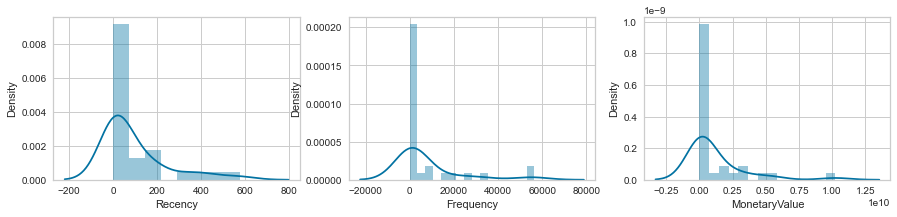

In [83]:
#plotando a RFM
print(df_rfm_raw.skew())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

for i in range(3):
    sns.distplot(df_rfm_raw.iloc[:,i], ax=ax[i])

In [84]:
#Acima da figura estão impressos os valores de skew de cada variável, uma medida de assimetria; quanto mais distantes de zero, mais assimétricas são as distribuições.

#Podemos aplicar transformações de potência para aumentar a simetria das distribuições, tornando-as mais "gaussianas". Para isso, utilizaremos a função power_transform do módulo sklearn.preprocessing:

In [85]:
arr_rfm = sklearn.preprocessing.power_transform(df_rfm_raw)

df_rfm = pd.DataFrame(arr_rfm,
                      index = df_rfm_raw.index,
                      columns = df_rfm_raw.columns)

In [86]:
#Visualizando as distribuições resultantes:

Recency          0.081048
Frequency       -0.002759
MonetaryValue   -0.033373
dtype: float64


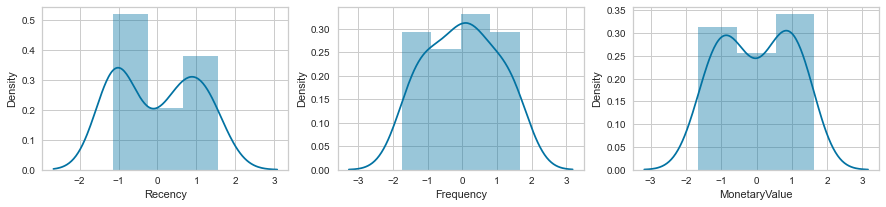

In [87]:
print(df_rfm.skew())

fig, ax = plt.subplots(1, 3, figsize=(15,3))

for i in range(3):
    sns.distplot(df_rfm.iloc[:,i], ax=ax[i])

In [88]:
#normalizemos as variáveis para que todas tenham média  0  e desvio-padrão  1 :

In [89]:
df_rfm = (df_rfm-df_rfm.mean())/df_rfm.std()

In [90]:
#Essa normalização faz com que as variáveis se distribuam em torno do mesmo ponto e com o mesmo grau de espalhamento, o que pode ajudar bastante a aplicação do algoritmo.

In [91]:
#  MOMELAGEM
#O primeiro passo é calcular as curvas de inércia e silhueta em função de  𝑘  de modo a tentar encontrar uma pista para um bom número de clusters:

In [92]:
#Método do cotovelo¶
#No método do cotovelo, a inércia é plotada em função do número de clusters, como abaixo:

In [93]:
def plot_inercia_per_k (X, k_list, ax = None):

    ax = ax or plt.gca()
    
    kmeans_per_k = [sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(X)
                    for k in k_list]

    inercias = [m.inertia_ for m in kmeans_per_k]

    ax.plot(k_list, inercias,ls='-',marker='*')

    ax.set_xlabel('$k$')
    ax.set_ylabel('inércia')
    
    return kmeans_per_k

In [94]:
#A função silhouette_score retorna uma métrica definida como a média das silhuetas de todas as observações. Abaixo, visualizamos um gráfico dessa métrica em função do número de clusters:

In [95]:
def plot_silhueta_per_k(X, k_list, ax = None):

    ax = ax or plt.gca()
    
    kmeans_per_k = [sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(X)
                    for k in k_list]

    silhuetas = [sklearn.metrics.silhouette_score(X, m.labels_) for m in kmeans_per_k]

    ax.plot(k_list, silhuetas,ls='-',marker='*')

    ax.set_xlabel('$k$')
    ax.set_ylabel('silhueta média')
    
    return kmeans_per_k

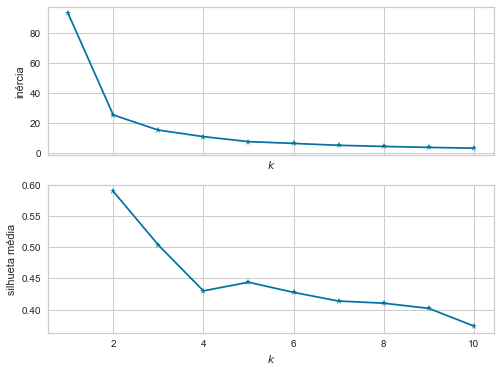

In [96]:
fig, ax = plt.subplots(2,1, figsize = (8,6), sharex=True)

kmeans_per_k = plot_inercia_per_k(df_rfm, range(1,11), ax=ax[0])
plot_silhueta_per_k(df_rfm, range(2,11), ax=ax[1]);

In [97]:
#As curvas não são muito informativas. Em particular, na curva de inércia, fora o ponto  𝑘=2 , as demais inflexões são muito sutis. Isso dificulta a escolha visual em que se baseia o método do cotovelo.

#Checando os diagramas de silhueta:

In [98]:
def plot_silhueta(X, k_list):
        
    n_lines = int(np.ceil(len(k_list)/2))    
    
    fig, ax = plt.subplots(n_lines, 2, figsize = (16,4*n_lines))

    for i in range(len(k_list)):

        m = sklearn.cluster.KMeans(k_list[i])
        yellowbrick.cluster.silhouette_visualizer(m, X, show=False, ax=ax.ravel()[i]);

    fig.tight_layout()

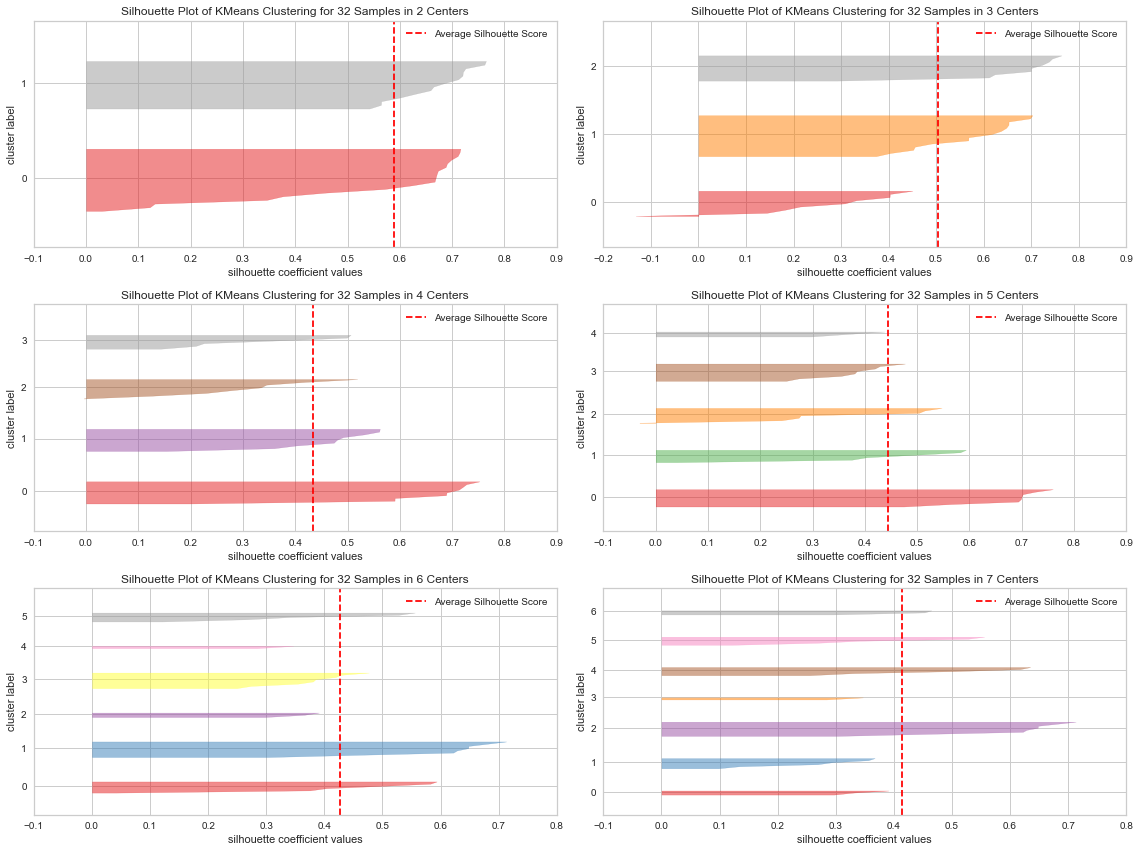

In [99]:
plot_silhueta(df_rfm, [2,3,4,5,6,7])

In [100]:
# Nos gráficos acima, cada figura em forma de faca corresponde a um cluster e contém os coeficientes de silhueta de suas observações.

# A altura de cada figura indica o tamanho (quantidade de observações) de cada cluster.

# Quanto mais comprida for uma figura, mais os coeficientes de silhueta do cluster correspondente aproximam-se de  1 , o valor ótimo.

# A análise dos gráficos indicaria que  𝑘=2  ou  4  seriam escolhas razoáveis, já que em todos os clusters as figuras estendem-se além da linha vertical que representa a silhueta média.

# Na prática, a escolha por  𝑘=4  poderia ser feita de modo a gerar clusters de tamanhos semelhantes.

In [101]:
#É possível visualizar o espaço RFM em gráficos 3d. Abaixo são comparadas duas escolhas,  𝑘=2  e  𝑘=4 :

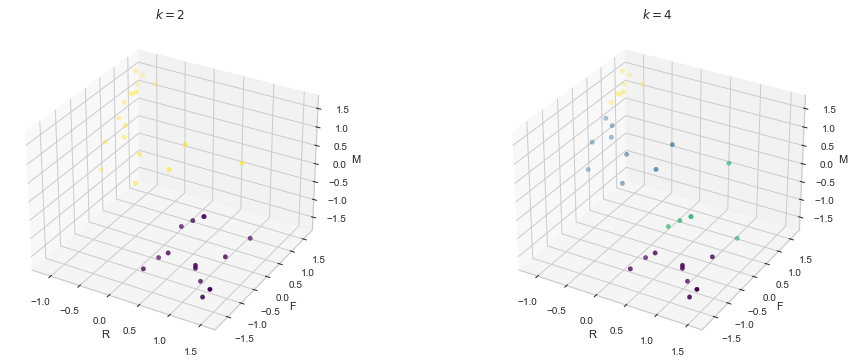

In [102]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection':'3d'}, figsize=(16,6))

k = [1,3]

for i in range(len(k)):

    ax[i].scatter(df_rfm.iloc[:,0], df_rfm.iloc[:,1], df_rfm.iloc[:,2],
                  c=kmeans_per_k[k[i]].labels_, cmap='viridis')

    ax[i].set_title(f'$k={k[i]+1}$')
    
    ax[i].set_xlabel('R')
    ax[i].set_ylabel('F')
    ax[i].set_zlabel('M')

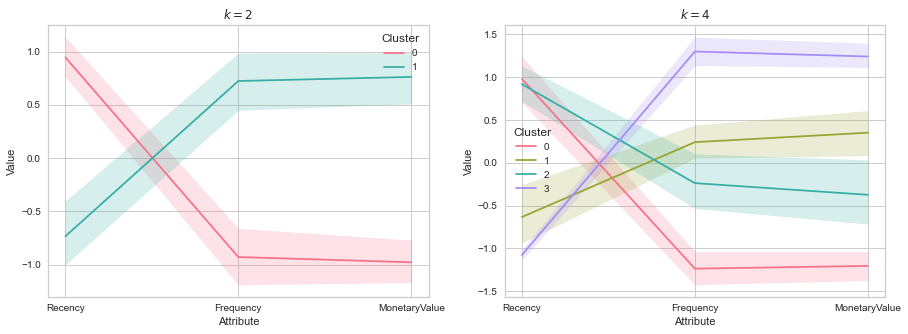

In [103]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

k = [1,3]

for i in range(len(k)):
    
    df_tmp = copy.deepcopy(df_rfm)
    df_tmp['ID'] = df_rfm.index
    df_tmp['Cluster'] = kmeans_per_k[k[i]].labels_
    df_tmp_melt = pd.melt(df_tmp.reset_index(),
                          id_vars=['ID', 'Cluster'],
                          value_vars=['Recency','Frequency','MonetaryValue'],
                          var_name='Attribute',
                          value_name='Value')

    sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_tmp_melt, 
                 ax=ax[i], palette = sns.color_palette("husl", k[i]+1))
    
    ax[i].set_title(f'$k={k[i]+1}$')

In [123]:
# Import the necessary packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
# Define a normalizer
normalizer = Normalizer()
# Create Kmeans model
kmeans = KMeans(n_clusters = 4,max_iter = 1000)
# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)
# Fit pipeline to daily stock movements
pipeline.fit(df_rfm)
labels = pipeline.predict(df_rfm)

In [124]:
df1 = pd.DataFrame({'labels':labels,'Commodities':list(df_rfm.index)}).sort_values(by=['labels'],axis = 0)
#labels
df1

labels             Commodities
15       0             GAS NATURAL
19       0        MINERIO DE FERRO
17       0                GASOLINA
29       1                   TRIGO
28       1         SUCO DE LARANJA
26       1                   PRATA
25       1                 PLATINA
23       1                 PALADIO
16       1                 GASOLEO
30       1                   UREIA
12       1        ENERGIA ELETRICA
0        1                     ACO
10       1                  CHUMBO
2        1          ACUCAR BRL D_0
9        1                  CARVAO
7        1                BORRACHA
5        1  BOBINA DE ACO LAMINADO
1        2                  ACUCAR
27       2                    SOJA
3        2                 ALGODAO
4        2                ALUMINIO
24       2                PETROLEO
21       2                    OLEO
11       2                   COBRE
20       2                  NIQUEL
6        2                     BOI
18       2                   MILHO
8        2                    CAFE
14       2                  ETANOL
22       2                    OURO
13       3                 ESTANHO
31       3                   ZINCO

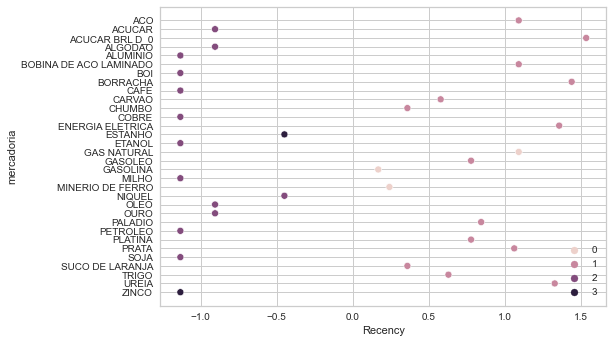

In [136]:
# Mostra o Gráfico de Clusters
#sns.scatterplot(x=df_rfm.Recency, y=df_rfm.index, hue=labels)
#plt.show()

In [145]:
df.head()

anomes mercadoria                         tipo  bolsa  \
data_referencia                                                         
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   
2019-07-24       20197       OLEO  NY HARBOR ULSD FUTURES (HO)  NYMEX   

                unidade_negociacao      moeda  quantidade_negociada  \
data_referencia                                                       
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   
2019-07-24                   GALAO  (220) USD               3444000   

                comprador_vendedor cod_ric cod_ticker  ...  valor_cotacao  \
data_referencia                                        ...                  
2019-07-24       Mercado x Cliente    HOH0       HOH0  ...         1.9152   
2019-07-24       Mercado x Cliente    HOX0       HOX0  ...         1.8636   
2019-07-24       Mercado x Cliente    HOJ1       HOJ1  ...         1.8315   
2019-07-24       Mercado x Cliente    HOV9       HOV9  ...         1.9676   
2019-07-24       Mercado x Cliente    HOX9       HOX9  ...         1.9630   

                    usd  notional_usd  notional_brl  mes   ano  ipca  \
data_referencia                                                        
2019-07-24       3.7596     6595948.8  2.479813e+07    7  2019  0.19   
2019-07-24       3.7596     6418238.4  2.413001e+07    7  2019  0.19   
2019-07-24       3.7596     6307686.0  2.371438e+07    7  2019  0.19   
2019-07-24       3.7596     6776414.4  2.547661e+07    7  2019  0.19   
2019-07-24       3.7596     6760572.0  2.541705e+07    7  2019  0.19   

                 ipca_acumulado  notionalusd_ipca  notionalusd_norm  
data_referencia                                                      
2019-07-24                  2.4        522179.280          0.333448  
2019-07-24                  2.4        508110.540          0.319319  
2019-07-24                  2.4        499358.475          0.310530  
2019-07-24                  2.4        536466.140          0.347796  
2019-07-24                  2.4        535211.950          0.346536  

[5 rows x 21 columns]

In [147]:
df_hie = df[['mercadoria','notionalusd_ipca']]

In [148]:
df_hie

mercadoria  notionalusd_ipca
data_referencia                             
2019-07-24            OLEO     522179.280000
2019-07-24            OLEO     508110.540000
2019-07-24            OLEO     499358.475000
2019-07-24            OLEO     536466.140000
2019-07-24            OLEO     535211.950000
...                    ...               ...
2022-05-18        PETROLEO      64823.830435
2022-05-18        PETROLEO      56373.230435
2022-05-18        PETROLEO      63639.226087
2022-05-18        PETROLEO      55948.800000
2022-05-18        PETROLEO      62562.313043

[242578 rows x 2 columns]

In [149]:
df_hie_res = df_hie.reset_index()
df_hie_res

data_referencia mercadoria  notionalusd_ipca
0           2019-07-24       OLEO     522179.280000
1           2019-07-24       OLEO     508110.540000
2           2019-07-24       OLEO     499358.475000
3           2019-07-24       OLEO     536466.140000
4           2019-07-24       OLEO     535211.950000
...                ...        ...               ...
242573      2022-05-18   PETROLEO      64823.830435
242574      2022-05-18   PETROLEO      56373.230435
242575      2022-05-18   PETROLEO      63639.226087
242576      2022-05-18   PETROLEO      55948.800000
242577      2022-05-18   PETROLEO      62562.313043

[242578 rows x 3 columns]

In [152]:
table = pd.pivot_table(df_hie_res,index='data_referencia',columns='mercadoria',values='notionalusd_ipca')  

In [153]:
table

mercadoria       ACO        ACUCAR  ACUCAR BRL D_0       ALGODAO  \
data_referencia                                                    
2019-07-24       NaN           NaN             NaN           NaN   
2019-08-23       NaN  10782.045153             NaN   2660.013280   
2019-08-26       NaN   6447.705792             NaN           NaN   
2019-08-27       NaN           NaN             NaN           NaN   
2019-08-28       NaN  33394.562550             NaN           NaN   
...              ...           ...             ...           ...   
2022-05-04       NaN   7076.519807             NaN  21514.420290   
2022-05-05       NaN  12502.520158             NaN           NaN   
2022-05-13       NaN   4220.978972             NaN           NaN   
2022-05-17       NaN   8739.072253             NaN   1160.925543   
2022-05-18       NaN           NaN             NaN           NaN   

mercadoria            ALUMINIO  BOBINA DE ACO LAMINADO            BOI  \
data_referencia                                                         
2019-07-24        26961.747685                     NaN            NaN   
2019-08-23        32520.119522                     NaN    2337.445219   
2019-08-26                 NaN                     NaN            NaN   
2019-08-27       152860.557769                     NaN            NaN   
2019-08-28       134580.179283                     NaN            NaN   
...                        ...                     ...            ...   
2022-05-04        12858.492351                     NaN   19495.260783   
2022-05-05        30196.290046                     NaN   26530.866522   
2022-05-13         1391.097826                     NaN   27263.521351   
2022-05-17                 NaN                     NaN   18825.652658   
2022-05-18         1453.423913                     NaN  176550.570839   

mercadoria       BORRACHA           CAFE  CARVAO  ...          OURO  PALADIO  \
data_referencia                                   ...                          
2019-07-24            NaN  113435.355392     NaN  ...           NaN      NaN   
2019-08-23            NaN   12297.519298     NaN  ...    134.180279      NaN   
2019-08-26            NaN    9138.545817     NaN  ...           NaN      NaN   
2019-08-27            NaN    3634.875498     NaN  ...           NaN      NaN   
2019-08-28            NaN    1824.559263     NaN  ...           NaN      NaN   
...                   ...            ...     ...  ...           ...      ...   
2022-05-04            NaN    3368.181289     NaN  ...           NaN      NaN   
2022-05-05            NaN    4851.363354     NaN  ...   2501.380870      NaN   
2022-05-13            NaN    3199.320652     NaN  ...   6862.434239      NaN   
2022-05-17            NaN   22057.906444     NaN  ...  14923.385507      NaN   
2022-05-18            NaN   38676.009078     NaN  ...           NaN      NaN   

mercadoria            PETROLEO  PLATINA  PRATA           SOJA  \
data_referencia                                                 
2019-07-24                 NaN      NaN    NaN  146620.625000   
2019-08-23                 NaN      NaN    NaN   37827.346380   
2019-08-26                 NaN      NaN    NaN   96017.396872   
2019-08-27                 NaN      NaN    NaN   55103.335906   
2019-08-28       141651.960402      NaN    NaN    9780.303785   
...                        ...      ...    ...            ...   
2022-05-04                 NaN      NaN    NaN   42115.213599   
2022-05-05                 NaN      NaN    NaN   37481.427174   
2022-05-13                 NaN      NaN    NaN   34383.103002   
2022-05-17                 NaN      NaN    NaN   32695.098966   
2022-05-18        57581.254282      NaN    NaN    7145.388517   

mercadoria       SUCO DE LARANJA  TRIGO  UREIA        ZINCO  
data_referencia                                              
2019-07-24                   NaN    NaN    NaN          NaN  
2019-08-23                   NaN    NaN    NaN          NaN  
2019-08-26                   N

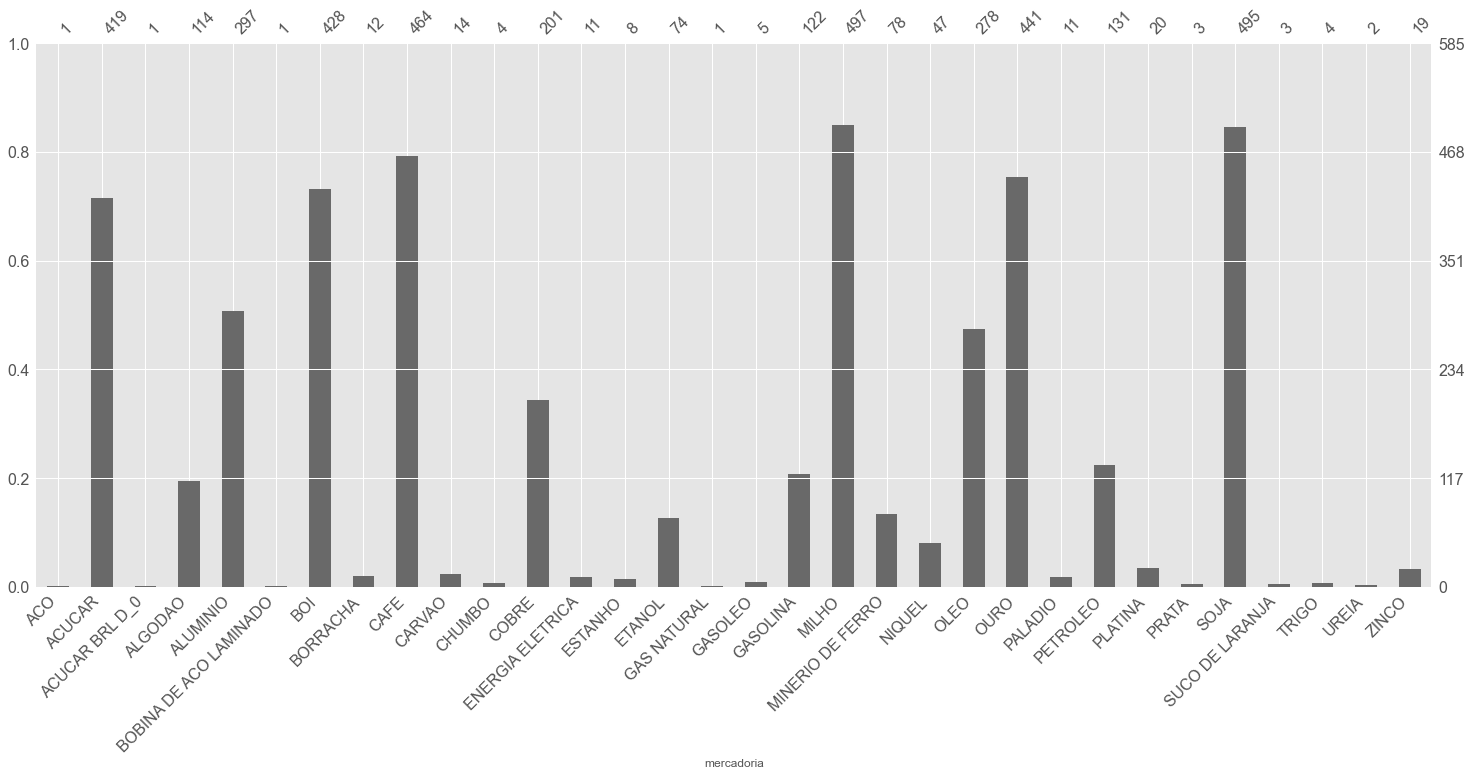

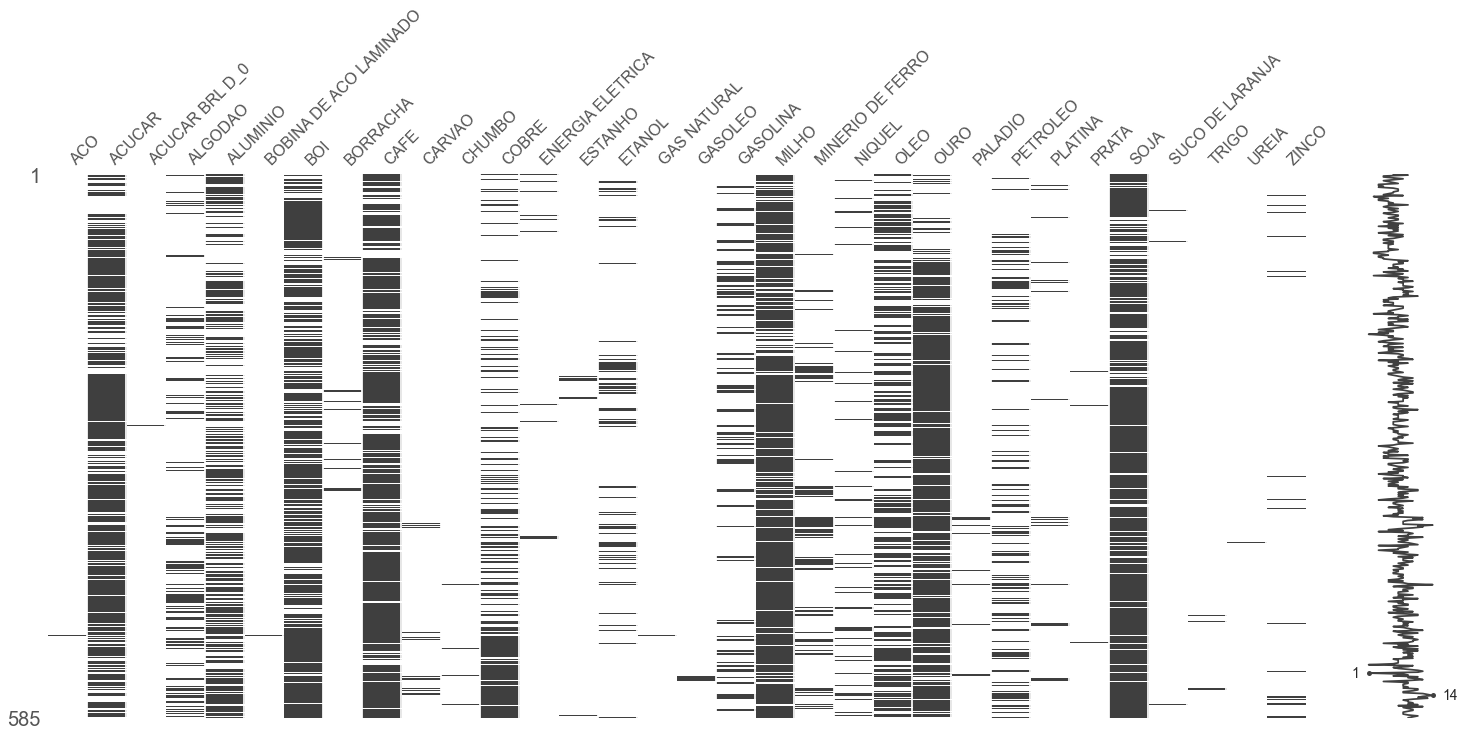

In [158]:
#Analisando o padrão de dados faltantes
missingno.bar(table)
missingno.matrix(table);

In [159]:
table.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 585 entries, 2019-07-24 to 2022-05-18
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ACO                     1 non-null      float64
 1   ACUCAR                  419 non-null    float64
 2   ACUCAR BRL D_0          1 non-null      float64
 3   ALGODAO                 114 non-null    float64
 4   ALUMINIO                297 non-null    float64
 5   BOBINA DE ACO LAMINADO  1 non-null      float64
 6   BOI                     428 non-null    float64
 7   BORRACHA                12 non-null     float64
 8   CAFE                    464 non-null    float64
 9   CARVAO                  14 non-null     float64
 10  CHUMBO                  4 non-null      float64
 11  COBRE                   201 non-null    float64
 12  ENERGIA ELETRICA        11 non-null     float64
 13  ESTANHO                 8 non-null      float64
 14  ETANOL                 

In [170]:
table.fillna(0)

mercadoria       ACO        ACUCAR  ACUCAR BRL D_0       ALGODAO  \
data_referencia                                                    
2019-07-24       0.0      0.000000             0.0      0.000000   
2019-08-23       0.0  10782.045153             0.0   2660.013280   
2019-08-26       0.0   6447.705792             0.0      0.000000   
2019-08-27       0.0      0.000000             0.0      0.000000   
2019-08-28       0.0  33394.562550             0.0      0.000000   
...              ...           ...             ...           ...   
2022-05-04       0.0   7076.519807             0.0  21514.420290   
2022-05-05       0.0  12502.520158             0.0      0.000000   
2022-05-13       0.0   4220.978972             0.0      0.000000   
2022-05-17       0.0   8739.072253             0.0   1160.925543   
2022-05-18       0.0      0.000000             0.0      0.000000   

mercadoria            ALUMINIO  BOBINA DE ACO LAMINADO            BOI  \
data_referencia                                                         
2019-07-24        26961.747685                     0.0       0.000000   
2019-08-23        32520.119522                     0.0    2337.445219   
2019-08-26            0.000000                     0.0       0.000000   
2019-08-27       152860.557769                     0.0       0.000000   
2019-08-28       134580.179283                     0.0       0.000000   
...                        ...                     ...            ...   
2022-05-04        12858.492351                     0.0   19495.260783   
2022-05-05        30196.290046                     0.0   26530.866522   
2022-05-13         1391.097826                     0.0   27263.521351   
2022-05-17            0.000000                     0.0   18825.652658   
2022-05-18         1453.423913                     0.0  176550.570839   

mercadoria       BORRACHA           CAFE  CARVAO  ...          OURO  PALADIO  \
data_referencia                                   ...                          
2019-07-24            0.0  113435.355392     0.0  ...      0.000000      0.0   
2019-08-23            0.0   12297.519298     0.0  ...    134.180279      0.0   
2019-08-26            0.0    9138.545817     0.0  ...      0.000000      0.0   
2019-08-27            0.0    3634.875498     0.0  ...      0.000000      0.0   
2019-08-28            0.0    1824.559263     0.0  ...      0.000000      0.0   
...                   ...            ...     ...  ...           ...      ...   
2022-05-04            0.0    3368.181289     0.0  ...      0.000000      0.0   
2022-05-05            0.0    4851.363354     0.0  ...   2501.380870      0.0   
2022-05-13            0.0    3199.320652     0.0  ...   6862.434239      0.0   
2022-05-17            0.0   22057.906444     0.0  ...  14923.385507      0.0   
2022-05-18            0.0   38676.009078     0.0  ...      0.000000      0.0   

mercadoria            PETROLEO  PLATINA  PRATA           SOJA  \
data_referencia                                                 
2019-07-24            0.000000      0.0    0.0  146620.625000   
2019-08-23            0.000000      0.0    0.0   37827.346380   
2019-08-26            0.000000      0.0    0.0   96017.396872   
2019-08-27            0.000000      0.0    0.0   55103.335906   
2019-08-28       141651.960402      0.0    0.0    9780.303785   
...                        ...      ...    ...            ...   
2022-05-04            0.000000      0.0    0.0   42115.213599   
2022-05-05            0.000000      0.0    0.0   37481.427174   
2022-05-13            0.000000      0.0    0.0   34383.103002   
2022-05-17            0.000000      0.0    0.0   32695.098966   
2022-05-18        57581.254282      0.0    0.0    7145.388517   

mercadoria       SUCO DE LARANJA  TRIGO  UREIA        ZINCO  
data_referencia                                              
2019-07-24                   0.0    0.0    0.0     0.000000  
2019-08-23                   0.0    0.0    0.0     0.000000  
2019-08-26                   0

In [178]:
#Tree Clustering

In [182]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
plt.style.use('ggplot')
#from ETFs import ETF
import numpy as np
%matplotlib inline

In [183]:
corr = table.corr()
cov = table.cov()

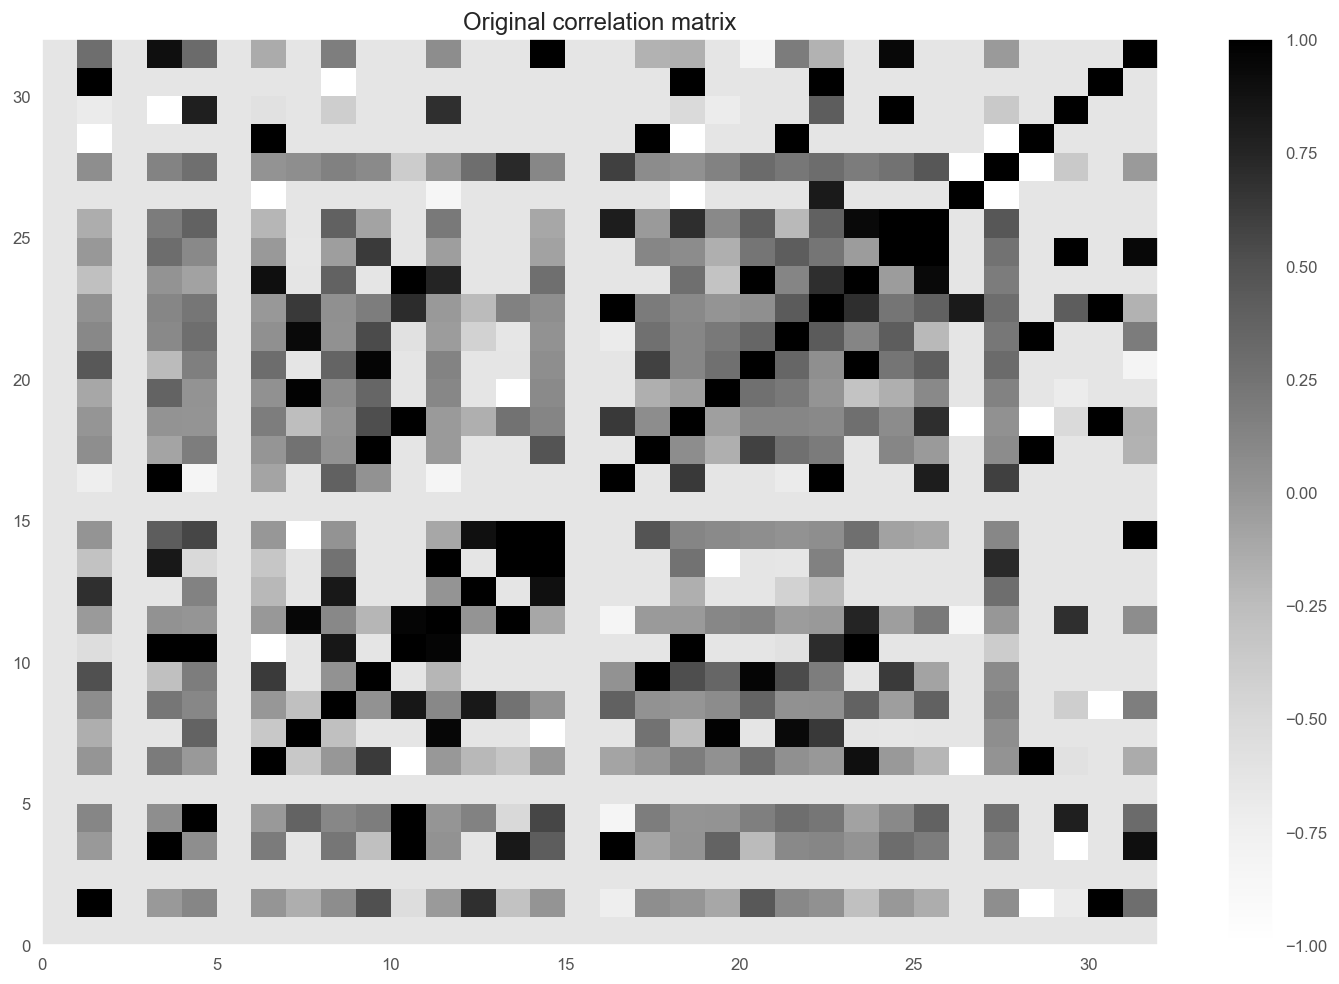

In [184]:
plt.figure(figsize=(15,10),dpi=120)
plt.pcolormesh(corr)
plt.colorbar()
plt.title('Original correlation matrix')
#plt.savefig(r'C:\Users\PC\Desktop\pic\original_corr_mat.jpeg', dpi=150)
plt.show()

In [185]:
# Distance Measure of original correlation matrix
d = np.sqrt((1 - corr) / 2)

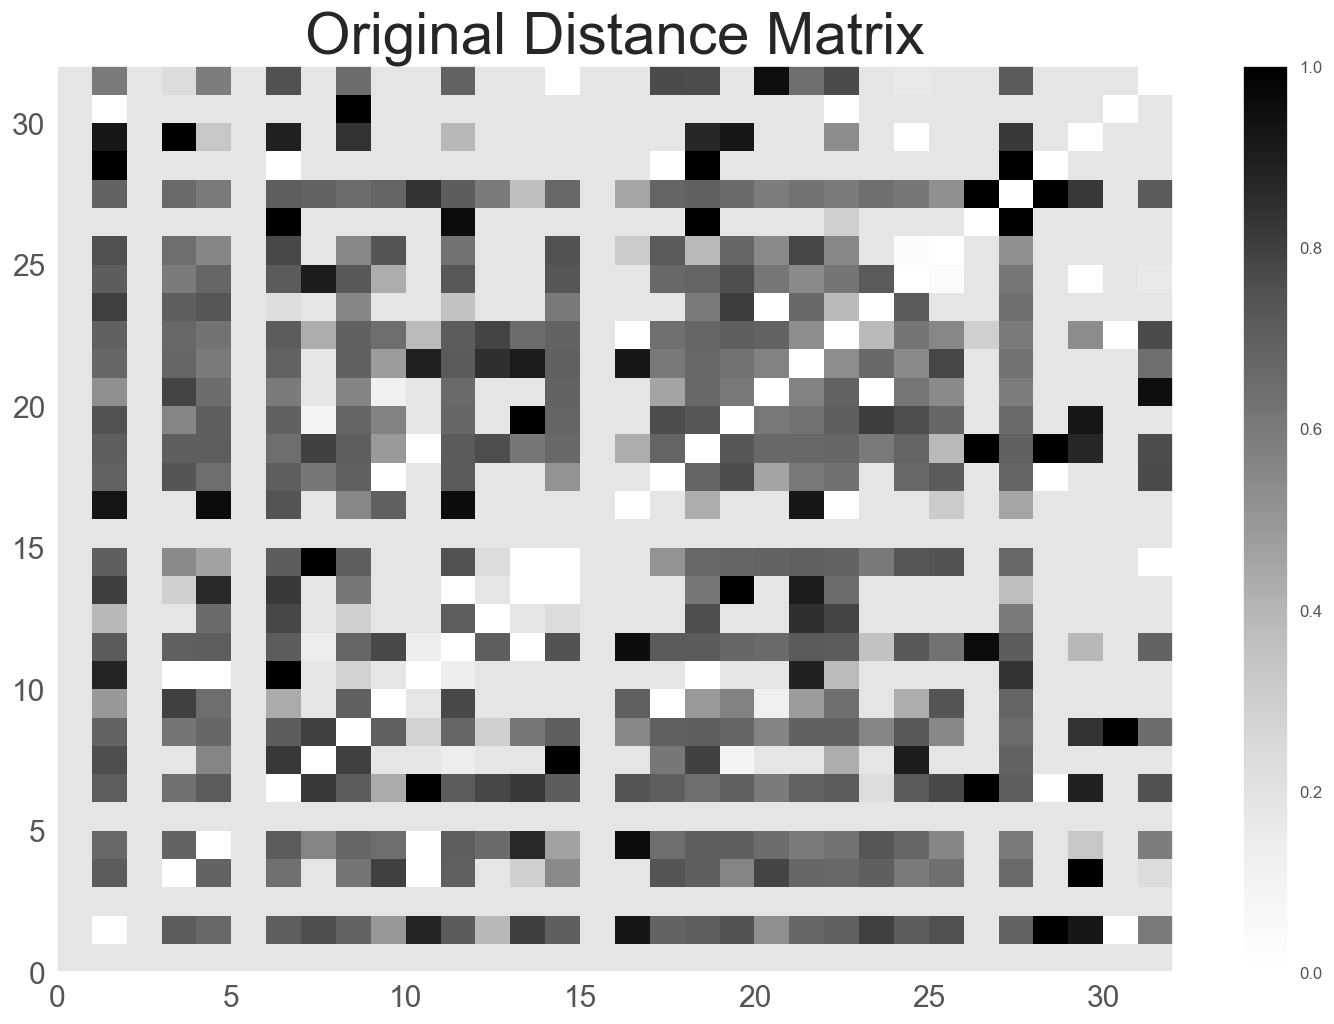

In [186]:
plt.figure(figsize=(15,10),dpi=120)
plt.pcolormesh(d)
plt.colorbar()
plt.title('Original Distance Matrix', fontsize=35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.savefig(r'C:\Users\PC\Desktop\pic\original_dist_mat.jpeg', dpi=150)
plt.show()

In [193]:

def tree_clustering(dist_mat, method="single", metric =  'eculidean'):
    flat_dist_mat = squareform(dist_mat) 
    res_linkage = linkage(flat_dist_mat, method=method, metric = metric)
    return res_linkage


linkage = tree_clustering(d)

ValueError: Distance matrix 'X' must be symmetric.